In [4]:
#import all the necessary packages for machine learning and data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import glob
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import json

2024-02-01 15:53:36.828098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [125]:
#change wprking directory
os.chdir('/Users/ajaytalbot/Library/CloudStorage/OneDrive-UniversityofToronto/Project_Research/Printability/316_mp_width')

In [127]:
#pandas datafram from the json file 
Ftr_lst = pd.read_json('MP_Data_input.json')
train_set = Ftr_lst
train_set.head()


Material  Power  Scanning_Speed  RPM  \
0       Ni   28.7           331.6  0.2   
1       Ni   35.5           280.7  0.2   
2       Ni   31.7           724.1  0.2   
3       Ni   57.5           757.6  0.2   
4       Ni   48.3           697.3  0.2   

                                          Mask_Array  Thermal Conductivity  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                87.864   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                87.864   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                87.864   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                87.864   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                87.864   

   Thermal Diffusivity  Specific Heat  Density  
0                 22.3          444.0     8900  
1                 22.3          444.0     8900  
2                 22.3          444.0     8900  
3                 22.3          444.0     8900  
4                 22.3          444.0     8900

In [ ]:
print(train_set.iloc[120])

In [128]:
#train set drop rows 154-156 
train_set = train_set.drop([2,6,57,60,61,88,90,149,154,155,156])
#reset index
train_set = train_set.reset_index(drop=True)


In [129]:
#drop all the rows withj SS316 in the material column
train_set = train_set[train_set['Material'] != 'SS316']

Data processing, train and test split, and normalizing 

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# One-hot encoding the 'Material' column
encoder = OneHotEncoder()
material_encoded = encoder.fit_transform(Ftr_lst[['Material']]).toarray()
encoded_feature_names = encoder.get_feature_names_out(['Material'])
Ftr_lst_encoded = pd.concat([Ftr_lst.drop('Material', axis=1), pd.DataFrame(material_encoded, columns=encoded_feature_names)], axis=1)

# Splitting the dataset into training and testing sets
train_set, test_set = train_test_split(Ftr_lst_encoded, test_size=0.2, random_state=42)

# Separating features and target variable for normalization
numerical_cols = ['Power', 'Scanning_Speed', 'RPM', 'Thermal Conductivity', 'Thermal Diffusivity', 'Specific Heat', 'Density']
X_train = train_set[numerical_cols]
X_test = test_set[numerical_cols]

# Normalizing the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Applying the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

# Replace the original columns in the train and test sets
train_set[numerical_cols] = X_train_scaled
test_set[numerical_cols] = X_test_scaled

#turn both train and test into a dataframe
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
#drop row [154-156] 

train_set = train_set.drop([156])

# Displaying the first few rows of the processed train set
train_set.head()


Power  Scanning_Speed       RPM  \
414 -1.472171       -1.284057  1.389898   
305 -0.137458       -0.018236  0.008595   
22   1.651058        0.913197 -0.451840   
307 -0.048477       -0.018236  0.008595   
46  -0.502279       -0.323615  0.469029   

                                            Mask_Array  Thermal Conductivity  \
414  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...             -0.685856   
305  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...             -0.685856   
22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...              1.498324   
307  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...             -0.685856   
46   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...              1.498324   

     Thermal Diffusivity  Specific Heat   Density  Material_316SS  \
414            -0.685954       0.658487 -0.685670             1.0   
305            -0.685954       0.658487 -0.685670             1.0   
22              1.439656      -0.828714  1.519587             0.0   
307            -0.685954       0.658487 -0.685670             1.0   
46              1.439656      -0.828714  1.519587             0.0   

     Material_Co  Material_Ni  Material_NiCo  
414          0.0          0.0            0.0  
305          0.0          0.0            0.0  
22           0.0          1.0            0.0  
307          0.0          0.0            0.0  
46           0.0          1.0            0.0

In [140]:
#reset the index of the train set
train_set_pca = train_set.reset_index(drop=True)

In [131]:
import numpy as np
import cv2
from scipy.ndimage import center_of_mass

def calculate_center_of_mass(image_array):
    # Assuming image_array is a NumPy array representing the grayscale image
    # where the intensity of each pixel is proportional to its contribution to the mass.
    return center_of_mass(image_array)

def crop_image_around_center(image_array, crop_width, crop_height):
    # Calculate the center of mass of the image
    center = calculate_center_of_mass(image_array)
    center_y, center_x = int(center[0]), int(center[1])

    # Define the start and end coordinates for y-axis and x-axis
    start_x = max(center_x - crop_width // 2, 0)
    end_x = start_x + crop_width
    start_y = max(center_y - crop_height // 2, 0)
    end_y = start_y + crop_height

    # Ensure the end coordinates do not exceed the image dimensions
    if end_x > image_array.shape[1]:
        end_x = image_array.shape[1]
        start_x = end_x - crop_width
    if end_y > image_array.shape[0]:
        end_y = image_array.shape[0]
        start_y = end_y - crop_height

    # Crop and return the image
    return image_array[start_y:end_y, start_x:end_x]

# Example usage:
# Load an image using OpenCV (assuming you have a file path)
# image = cv2.imread('path_to_your_image.png', cv2.IMREAD_GRAYSCALE)

# Let's say we have the image in a variable called `image_array`
# and we want to crop it to a size of 64x96 pixels.
# cropped_image = crop_image_around_center(image_array, 96, 64)

# Save or further process `cropped_image` as needed



In [141]:
#reduce the size of each mask array to 64x96
for i in range(len(train_set_pca['Mask_Array'])):
    train_set_pca['Mask_Array'][i] = crop_image_around_center(np.array(train_set_pca['Mask_Array'][i]), 400, 400)

/var/folders/by/cl20h8994bq9jtq1mdk23hmc0000gn/T/ipykernel_66486/2025112818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_pca['Mask_Array'][i] = crop_image_around_center(np.array(train_set_pca['Mask_Array'][i]), 400, 400)


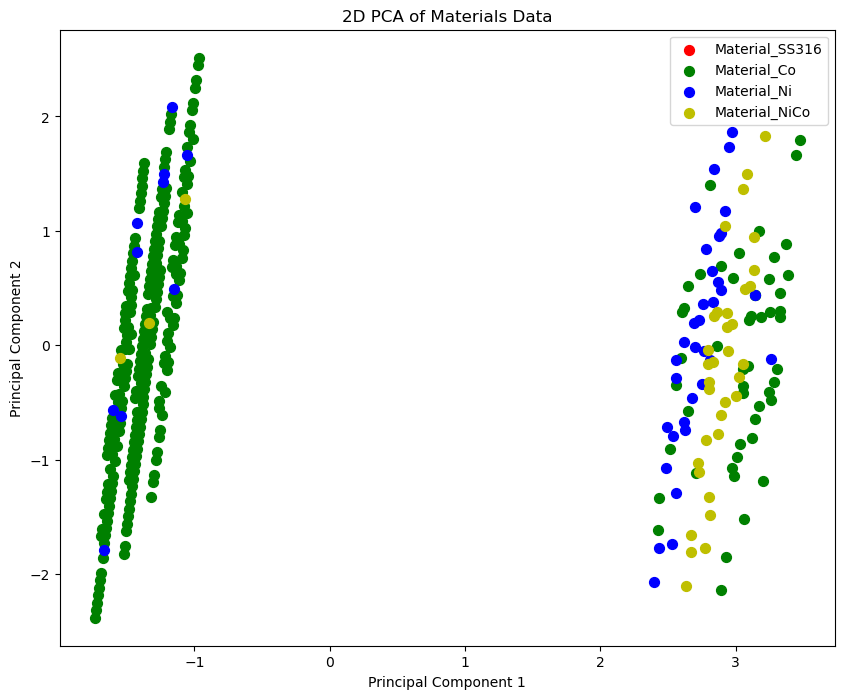

In [144]:
####PCA IF YOU WANT####
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Extracting material type based on one-hot encoding
material_columns = [ 'Material_Co', 'Material_Ni', 'Material_NiCo']
train_set_material = train_set[material_columns]
train_set['material_type'] = train_set_material.idxmax(axis=1)

# Applying PCA on the scaled numerical data (assuming 'X_train_scaled' contains your scaled data)
pca = PCA(n_components=2)  # Using 2 components for 2D visualization
X_train_pca = pca.fit_transform(X_train_scaled)

# Preparing the DataFrame for visualization
visualization_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
visualization_df['material_type'] = train_set['material_type'].reset_index(drop=True)

# Plotting the PCA components with colors
plt.figure(figsize=(10, 8))
colors = { 'Material_SS316':'r','Material_Co': 'g', 'Material_Ni': 'b', 'Material_NiCo': 'y'}

for material, color in colors.items():
    indicesToKeep = visualization_df['material_type'] == material
    plt.scatter(visualization_df.loc[indicesToKeep, 'PC1'], visualization_df.loc[indicesToKeep, 'PC2'], c=color, s=50, label=material)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Materials Data')
plt.legend()
plt.show()


In [ ]:


#convert each list in the mask array column into an array
train_set['Mask_Array'] = train_set['Mask_Array'].apply(np.array)


In [ ]:
#convert each numpy array into a tensor
train_set['Mask_Array'] = train_set['Mask_Array'].apply(lambda x: tf.convert_to_tensor(x) if x is not None else None)


In [ ]:
#type of each element in the mask array column
train_set['Mask_Array'].apply(type).value_counts()
#print the index of the first row that has a None value in the mask array column
train_set[train_set['Mask_Array'].isnull()].index[0]
#drop the row with the None value in the mask array column
train_set.drop(train_set[train_set['Mask_Array'].isnull()].index[0], inplace=True)

In [ ]:
# convert train_set['Mask_Array'] back into a numpy array
train_set['Mask_Array'] = train_set['Mask_Array'].apply(lambda x: x.numpy())

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np


In [ ]:
# Drop rows with None values in 'Mask_Array'
train_set.dropna(subset=['Mask_Array'], inplace=True)
#drop material column
train_set = train_set.drop(['Material'], axis=1)

# Convert 'Mask_Array' to numpy arrays and flatten them
def preprocess_masks(mask):
    return np.array(mask).flatten()

train_set['Mask_Array'] = train_set['Mask_Array'].apply(preprocess_masks)

# Check that all masks are now flat and of the same length
#assert all(len(mask) == 640*640 for mask in train_set['Mask_Array']), "Masks are not all the same size."

# Splitting the data into features and target
X = train_set.drop('Mask_Array', axis=1)
y = np.stack(train_set['Mask_Array'].values)

# Splitting the dataset into training and test sets
X_train, X_test_new, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('estimator', TransformedTargetRegressor(
        regressor=MLPRegressor(alpha=0.001,
                               hidden_layer_sizes=(32, 128, 100),
                               learning_rate_init=0.01,
                               max_iter=1000000,
                               n_iter_no_change=200,
                               random_state=42,
                               verbose=True),
        transformer=PCA(n_components=69)
    ))
])
#we need to perform hyperparameter tuning for the MLPRegressor
#we can use the GridSearchCV class from sklearn.model_selection
from sklearn.model_selection import GridSearchCV


# Defining the hyperparameter grid
param_grid = {
    'estimator__regressor__alpha': [0.001, 0.01, 0.1],
    'estimator__regressor__hidden_layer_sizes': [(32, 128, 100), (64, 256, 200), (128, 512, 400)],
    'estimator__regressor__learning_rate_init': [0.001, 0.01, 0.1]
}

# Instantiating the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)

# Fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Extracting the best estimator
pipeline = grid_search.best_estimator_

# Extracting the best score
grid_search.best_score_

# Extracting the best hyperparameters
grid_search.best_params_

# The pipeline is now fitted and can be used to predict, etc.



#what order should the inputs be in for the model to predict the mask array

Power	Scanning_Speed	RPM		Thermal Conductivity	Thermal Diffusivity	Specific Heat	Density |
28.7	  331.6	0.2		87.864	22.3	444.0	8900

In [15]:
# Drop rows with None values in 'Mask_Array'
train_set.dropna(subset=['Mask_Array'], inplace=True)
#drop material column
train_set = train_set.drop(['Material'], axis=1)


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:


# Convert 'Mask_Array' to numpy arrays and flatten them
def preprocess_masks(mask):
    return np.array(mask).flatten()

train_set['Mask_Array'] = train_set['Mask_Array'].apply(preprocess_masks)

# Check that all masks are now flat and of the same length
#assert all(len(mask) == 640*640 for mask in train_set['Mask_Array']), "Masks are not all the same size."

# Splitting the data into features and target
X = train_set.drop('Mask_Array', axis=1)
y = np.stack(train_set['Mask_Array'].values)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




pipeline2 = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('estimator', TransformedTargetRegressor(
        regressor=MLPRegressor(alpha=0.001,
                               learning_rate_init=0.1,
                               hidden_layer_sizes=(128,512,400),
                               max_iter=1000000,
                               n_iter_no_change=200,
                               random_state=42,
                               verbose=False),
        transformer=PCA(n_components=69)
    ))
])
pipeline2.fit(X_train, y_train)

/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_target.py:190: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(


Pipeline(steps=[('preprocessor', StandardScaler()),
                ('estimator',
                 TransformedTargetRegressor(regressor=MLPRegressor(alpha=0.001,
                                                                   hidden_layer_sizes=(128,
                                                                                       512,
                                                                                       400),
                                                                   learning_rate_init=0.1,
                                                                   max_iter=1000000,
                                                                   n_iter_no_change=200,
                                                                   random_state=42),
                                            transformer=PCA(n_components=69)))])

In [32]:
#how do I predict the mask array for a new set of features?
# Splitting the data into features and target
input_data = np.array([[36,280,	0.6,86.3995,22.4,433.5,8880]])
# The pipeline will automatically preprocess the new input data and make a prediction
predicted_mask_array = pipeline2.predict(input_data )

# If the output needs to be reshaped back into the (640x640) image format
predicted_images = [mask.reshape(400,400) for mask in predicted_mask_array]

/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


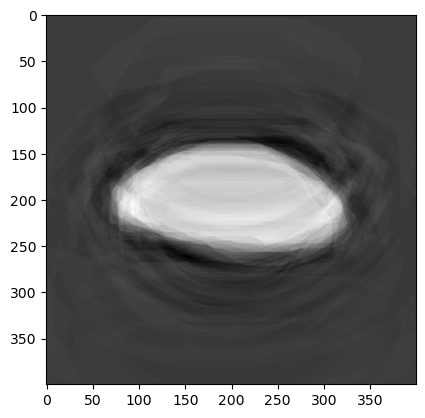

In [33]:
plt.imshow(predicted_images[0], cmap='gray')

In [21]:
#save the pipeline2 model so that it can be used elsewhere as a pickle 
import pickle
# Save the pipeline
with open('pipeline2_fixed.pkl', 'wb') as file:
    pickle.dump(pipeline2, file)


In [63]:
#import all the necessary libraries for the below code 
import numpy as np
import cv2
from skimage import filters, morphology, exposure
import matplotlib.pyplot as plt
import joblib



# Processing the 'final_image' to find width, height, and depth, then visualizing with accurate line lengths
PIXEL_TO_MM_RATIO = 245.5104 #pix/mm
model_mp = joblib.load('pipeline2_fixed.pkl')
def process_and_visualize(P,V,RPM,TH_Co,TH_DF,S_H,D, pixel_threshold=200):

    ###########Prediction###########
    predicted_mask_array = pipeline2.predict(np.array([[P,V,RPM,TH_Co,TH_DF,S_H,D]]))

    # If the output needs to be reshaped back into the (640x640) image format
    predicted_images = [mask.reshape(400,400) for mask in predicted_mask_array]



    ############Image Processing############
    # Convert image to grayscale if it is not already
    gray_image = cv2.cvtColor(predicted_images[0], cv2.COLOR_BGR2GRAY) if predicted_images[0].ndim == 3 else predicted_images[0]

    # Apply thresholding
    thresh_value = filters.threshold_otsu(gray_image)
    binary_image = gray_image > thresh_value

    # Apply morphological closing and opening to clean up small holes and noise
    cleaned_image = morphology.closing(binary_image, morphology.disk(10))  # You may need to adjust the kernel size
    cleaned_image = morphology.opening(cleaned_image, morphology.disk(10))

    # Detect edges
    edges = cv2.Canny((cleaned_image * 255).astype(np.uint8), 100, 200)

    # Find contours and draw them
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = cv2.drawContours(np.zeros_like(gray_image), contours, -1, (255, 0, 0), 1)

    # Sharpen image
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened_image = cv2.filter2D(contour_image, -1, sharpen_kernel)

    # Adjust contrast
    contrasted_image = exposure.rescale_intensity(sharpened_image, in_range='image', out_range=(0, 255))

    # Convert back to BGR if necessary for your model's output format
    image = cv2.cvtColor(contrasted_image, cv2.COLOR_GRAY2BGR) if predicted_images[0].ndim == 3 else contrasted_image





    #############Dimension Calculation#############
    # Function to find the first pixel exceeding the threshold
    def find_edge(start, end, axis, fixed_coord, threshold):
        for i in range(start, end, 1 if start < end else -1):
            if (axis == 'x' and image[fixed_coord, i] > threshold) or \
               (axis == 'y' and image[i, fixed_coord] > threshold):
                return i
        return None

    # Image center coordinates
    #x_center defined at point of maxium width 
    x_center = image.shape[1] // 2
    y_center = image.shape[0] // 2
    # Finding edge coordinates
    x_left = find_edge(x_center, 0, 'x', y_center, pixel_threshold)
    x_right = find_edge(x_center, image.shape[1], 'x', y_center, pixel_threshold)
    y_top = find_edge(y_center, 0, 'y', x_center, pixel_threshold)
    y_bottom = find_edge(y_center, image.shape[0], 'y', x_center, pixel_threshold)

    # Calculating dimensions
    width = abs(x_right - x_left) if x_left is not None and x_right is not None else 0
    height = abs(y_top - y_center) if y_top is not None else 0
    depth = abs(y_bottom - y_center) if y_bottom is not None else 0
    dilution = (height + depth) / width if width > 0 else 0

    # Convert dimensions from pixels to millimeters
    if width == 0:
        width_mm = 400 / PIXEL_TO_MM_RATIO
    else:
        width_mm = width / PIXEL_TO_MM_RATIO

    height_mm = height / PIXEL_TO_MM_RATIO
    depth_mm = depth / PIXEL_TO_MM_RATIO

    # Visualizing the results
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    if x_left is not None and x_right is not None:
        plt.plot([x_left, x_right], [y_center, y_center], 'r-', linewidth=2)  # Width
        plt.text((x_left + x_right) / 2, y_center, f'Width: {width_mm:.2f} mm', color='red')
    if y_top is not None:
        plt.plot([x_center, x_center], [y_center, y_top], 'b-', linewidth=2)  # Height
        plt.text(x_center, (y_center + y_top) / 2, f'Height: {height_mm:.2f} mm', color='blue', rotation=90)
    if y_bottom is not None:
        plt.plot([x_center, x_center], [y_center, y_bottom], 'g-', linewidth=2)  # Depth
        plt.text(x_center, (y_center + y_bottom) / 2, f'Depth: {depth_mm:.2f} mm', color='green', rotation=90)
    plt.text(10, 10, f'Dilution: {dilution:.2%}', color='white', backgroundcolor='black')
    plt.axis('off')
    plt.title("Melt Pool Dimensions")
    plt.show()

    return width_mm, height_mm, depth_mm, dilution

# Applying the function to the 'final_image'# Assuming 'adjusted_final_image' is the final image numpy array



/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


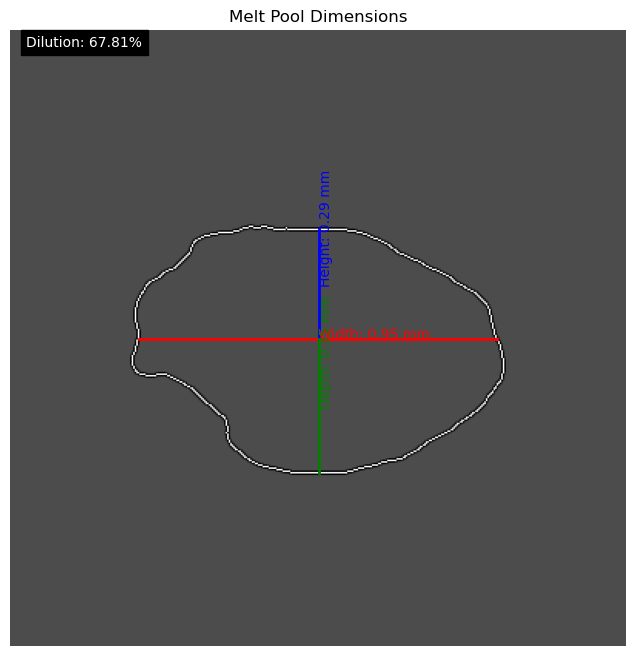

In [66]:
#return the width, height, depth, and dilution from the process_and_visualize function
width, height, depth, dilution = process_and_visualize(30.7,394.2,0.1,86.3995,22.4,433.5,8880)


NICO: 86.3995, 22.4, 433.5, 8880
Co: 8860, 423, 22.7, 84.935
Ni: 87.864,22.3,444,8900

/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


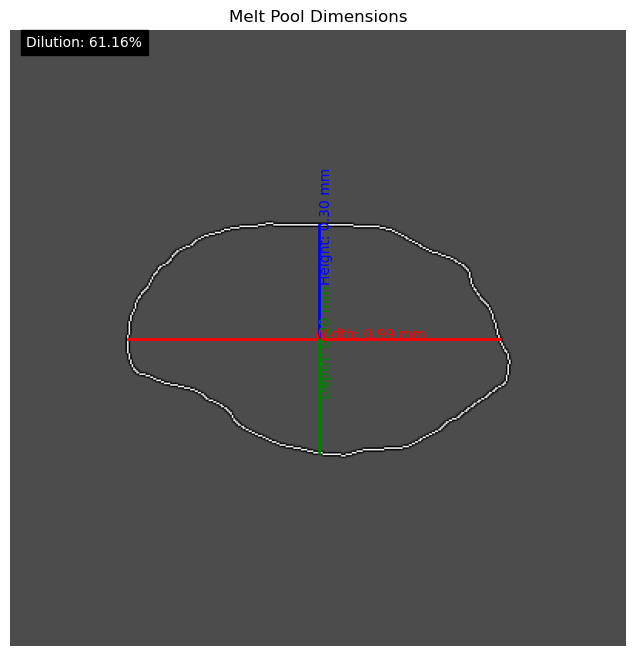

In [88]:
width, height, depth, dilution = process_and_visualize(35	,600	,0.3, 86.3995, 22.4, 433.5, 8880)

In [108]:
# Processing the 'final_image' to find width, height, and depth, then visualizing with accurate line lengths
#import all the necessary libraries for the below code 
import numpy as np
import cv2
from skimage import filters, morphology, exposure
import matplotlib.pyplot as plt
import joblib



PIXEL_TO_MM_RATIO = 245.5104 #pix/mm
model_mp = joblib.load('pipeline2_fixed.pkl')
def process_and_visualize(P,V,RPM,TH_Co,TH_DF,S_H,D, pixel_threshold=200):

    ###########Prediction###########
    predicted_mask_array = model_mp.predict(np.array([[P,V,RPM,TH_Co,TH_DF,S_H,D]]))

    # If the output needs to be reshaped back into the (640x640) image format
    predicted_images = [mask.reshape(400,400) for mask in predicted_mask_array]



    ############Image Processing############
    # Convert image to grayscale if it is not already
    gray_image = cv2.cvtColor(predicted_images[0], cv2.COLOR_BGR2GRAY) if predicted_images[0].ndim == 3 else predicted_images[0]

    # Apply thresholding
    thresh_value = filters.threshold_otsu(gray_image)
    binary_image = gray_image > thresh_value

    # Apply morphological closing and opening to clean up small holes and noise
    cleaned_image = morphology.closing(binary_image, morphology.disk(10))  # You may need to adjust the kernel size
    cleaned_image = morphology.opening(cleaned_image, morphology.disk(10))

    # Detect edges
    edges = cv2.Canny((cleaned_image * 255).astype(np.uint8), 100, 200)

    # Find contours and draw them
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = cv2.drawContours(np.zeros_like(gray_image), contours, -1, (255, 0, 0), 1)

    # Sharpen image
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened_image = cv2.filter2D(contour_image, -1, sharpen_kernel)

    # Adjust contrast
    contrasted_image = exposure.rescale_intensity(sharpened_image, in_range='image', out_range=(0, 255))

    # Convert back to BGR if necessary for your model's output format
    image = cv2.cvtColor(contrasted_image, cv2.COLOR_GRAY2BGR) if predicted_images[0].ndim == 3 else contrasted_image





    #############Dimension Calculation#############
    # Function to find the first pixel exceeding the threshold
    def find_edge(start, end, axis, fixed_coord, threshold):
        for i in range(start, end, 1 if start < end else -1):
            if (axis == 'x' and image[fixed_coord, i] > threshold) or \
               (axis == 'y' and image[i, fixed_coord] > threshold):
                return i
        return None

    # Image center coordinates
    x_center = image.shape[1] // 2
    y_center = image.shape[0] // 2

    # Finding edge coordinates
    x_left = find_edge(x_center, 0, 'x', y_center, pixel_threshold)
    x_right = find_edge(x_center, image.shape[1], 'x', y_center, pixel_threshold)
    y_top = find_edge(y_center, 0, 'y', x_center, pixel_threshold)
    y_bottom = find_edge(y_center, image.shape[0], 'y', x_center, pixel_threshold)

    # Calculating dimensions
    width = abs(x_right - x_left) if x_left is not None and x_right is not None else 0
    height = abs(y_top - y_center) if y_top is not None else 0
    depth = abs(y_bottom - y_center) if y_bottom is not None else 0
    dilution = (height + depth) / width if width > 0 else 0

    # Convert dimensions from pixels to millimeters
    if width == 0:
        width_mm = 300 / PIXEL_TO_MM_RATIO
    else:
        width_mm = width / PIXEL_TO_MM_RATIO

    height_mm = height / PIXEL_TO_MM_RATIO
    depth_mm = depth / PIXEL_TO_MM_RATIO

    # Visualizing the results
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    if x_left is not None and x_right is not None:
        plt.plot([x_left, x_right], [y_center, y_center], 'r-', linewidth=2)  # Width
        # plt.text((x_left + x_right) / 2, y_center, f'Width: {width_mm:.2f} mm', color='red')
    if y_top is not None:
        plt.plot([x_center, x_center], [y_center, y_top], 'b-', linewidth=2)  # Height
        # plt.text(x_center, (y_center + y_top) / 2, f'Height: {height_mm:.2f} mm', color='blue', rotation=90)
    if y_bottom is not None:
        plt.plot([x_center, x_center], [y_center, y_bottom], 'g-', linewidth=2)  # Depth
        # plt.text(x_center, (y_center + y_bottom) / 2, f'Depth: {depth_mm:.2f} mm', color='green', rotation=90)
    # plt.text(10, 10, f'Dilution: {dilution:.2%}', color='white', backgroundcolor='black')
    plt.axis('off')
    plt.title("Melt Pool Dimensions")
    #plt.show() Dont show the plot right now 
    

    return width_mm, height_mm, depth_mm, dilution

# Applying the function to the 'final_image'# Assuming 'adjusted_final_image' is the final image numpy array



FileNotFoundError: [Errno 2] No such file or directory: 'pipeline2_fixed.pkl'

In [90]:
os.chdir('/Users/ajaytalbot/Library/CloudStorage/OneDrive-UniversityofToronto/Project_Research/Printability/Code base/All Cubes')
#load the 'Nickel_Test_edit copy.csv' file
df = pd.read_csv('Optimization copy 2.csv')
#drop the first column
df = df.drop(df.columns[0], axis=1)
df.head()

idx_lsx  hs_opt_ls  w_ls   p_ls  ss_ls  rpm_1  rpm_2  t_ls
0        1        0.6  0.96     35    650    0.2    0.1   0.2
1        2        0.6  0.98     37    650    0.2    0.1   0.2
2        3        0.6  1.04     39    650    0.2    0.1   0.2
3        4        0.6  1.03     41    650    0.2    0.1   0.2
4        5        0.6  0.95     43    650    0.2    0.1   0.2

In [91]:
#print the column name of the 4th column
df.columns[3]

' p_ls'

In [105]:
#X_test_new is a dataframe with reset index
X_test_new = X_test.reset_index(drop=True)
X_test_new.head()

Power  Scanning_Speed  RPM  Thermal Conductivity  Thermal Diffusivity  \
0   53.0           480.0  0.5                13.530                3.598   
1   64.1           656.6  0.6                87.864               22.300   
2   46.0           720.0  0.8                13.530                3.598   
3   44.0           720.0  0.2                13.530                3.598   
4   56.0           720.0  0.2                13.530                3.598   

   Specific Heat  Density  Width  Height  
0          470.0     8230      0       0  
1          444.0     8900      0       0  
2          470.0     8230      0       0  
3          470.0     8230      0       0  
4          470.0     8230      0       0

In [112]:
#current working directory
os.getcwd()

'/Users/ajaytalbot/Library/CloudStorage/OneDrive-UniversityofToronto/Project_Research/Printability/Code base/All Cubes'

/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/var/folders/by/cl20h8994bq9jtq1mdk23hmc0000gn/T/ipykernel_66486/3489789635.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new['Width'][i] = pred[0]
/var/folders/by/cl20h8994bq9jtq1mdk23hmc0000gn/T/ipykernel_66486/3489789635.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_new['Height'][i] = pred[1]
/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not

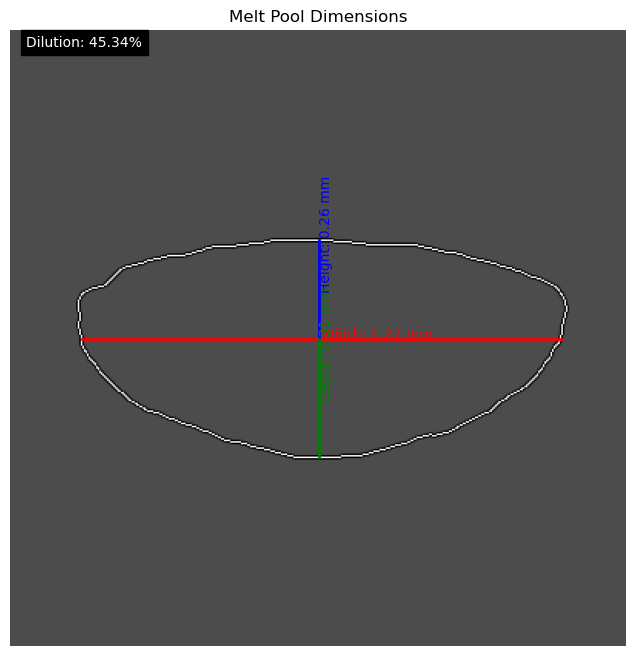

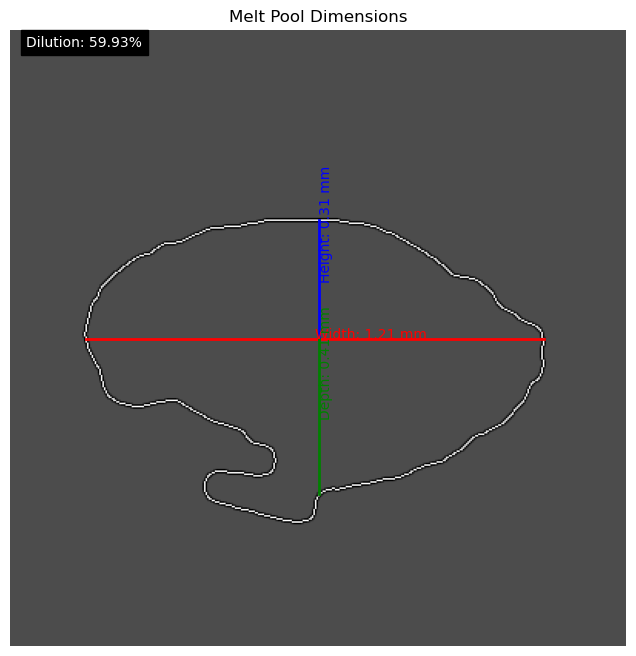

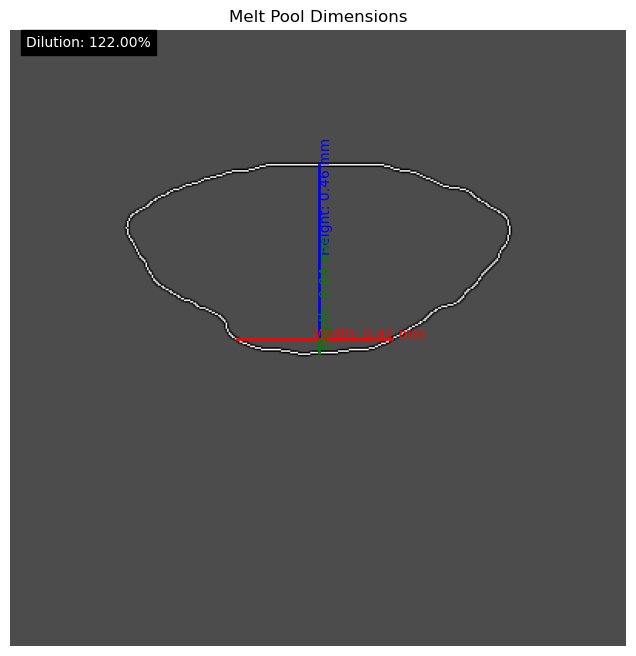

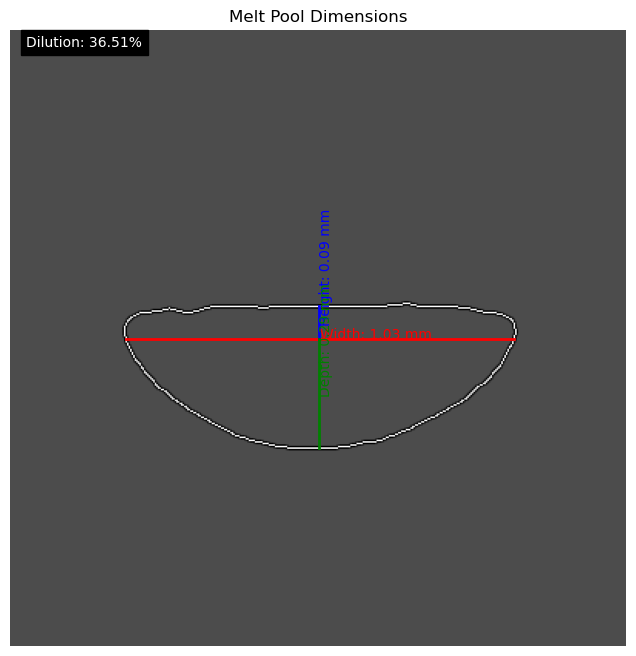

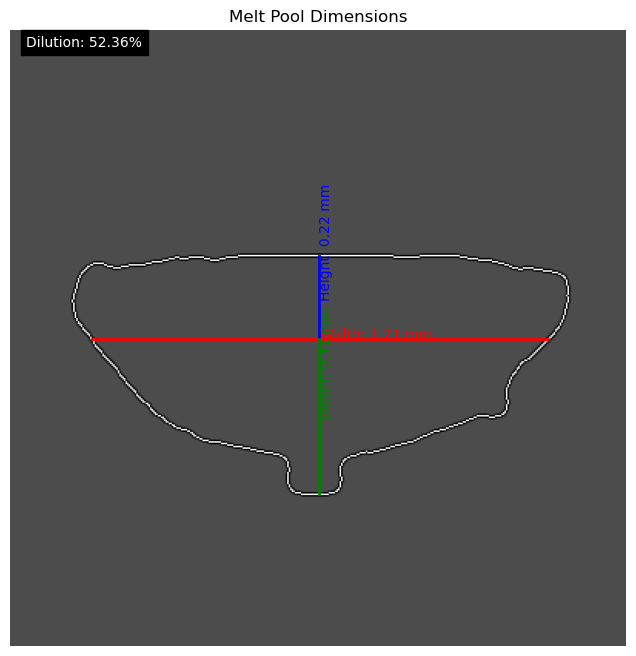

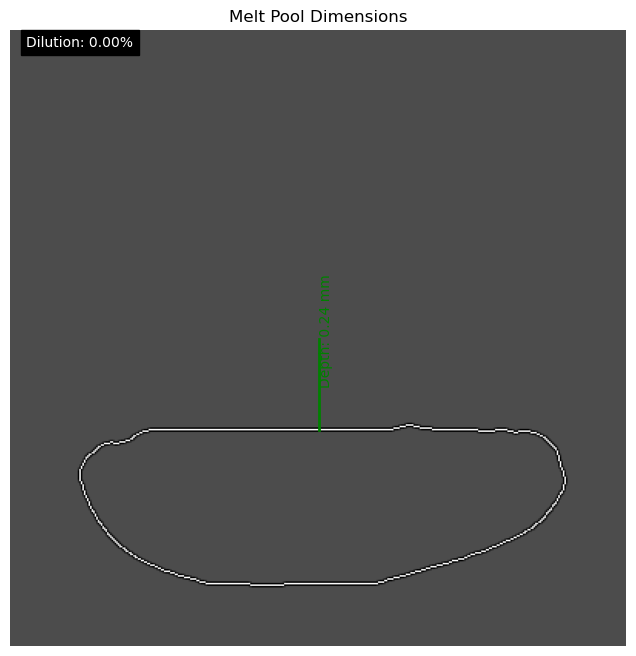

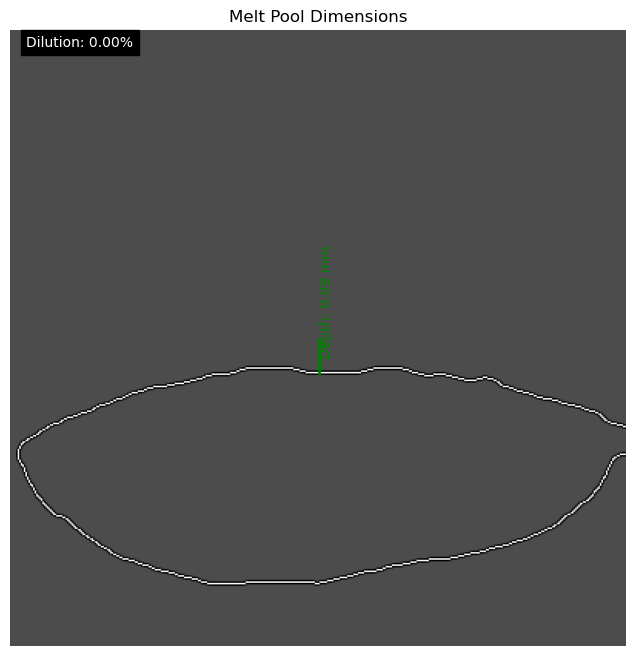

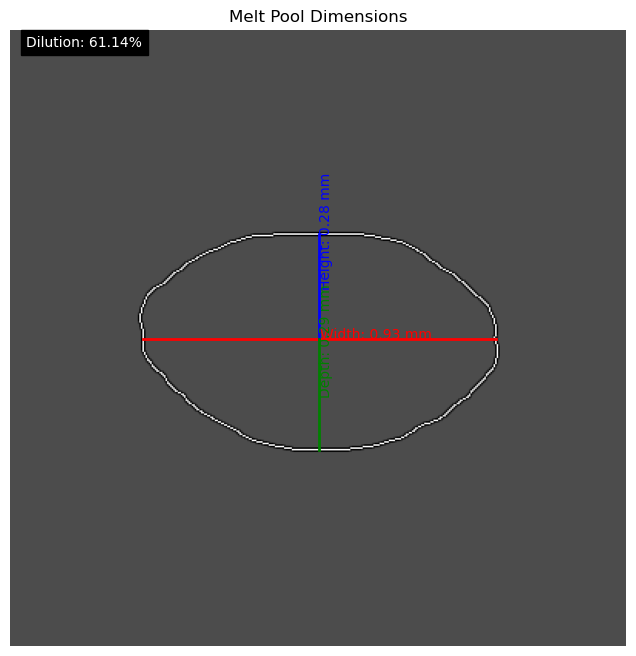

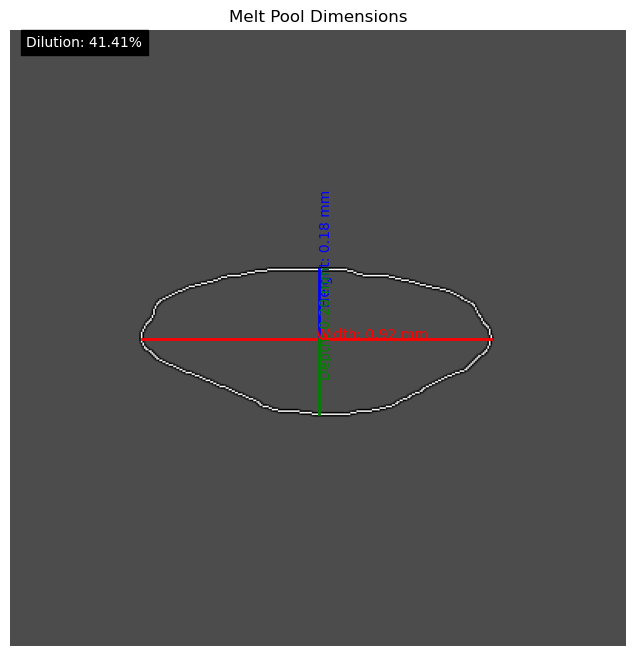

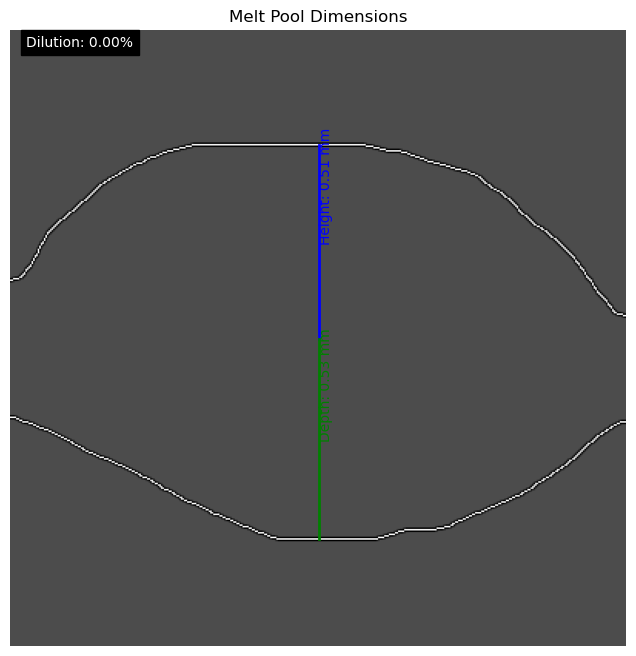

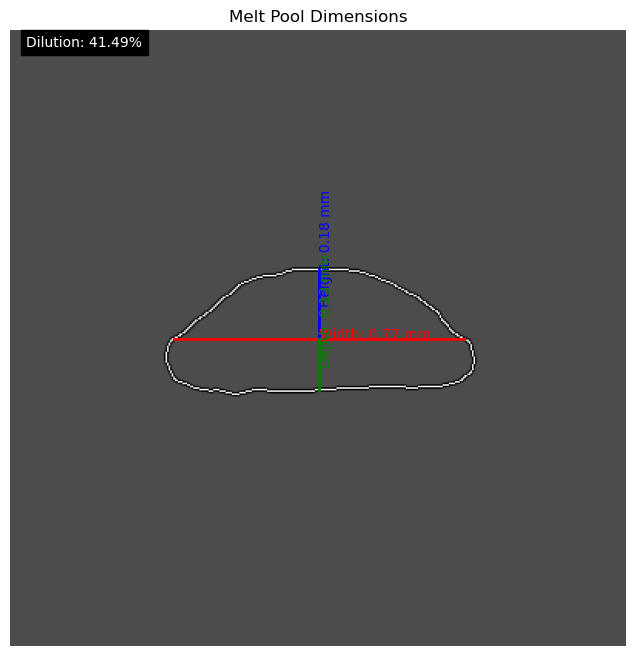

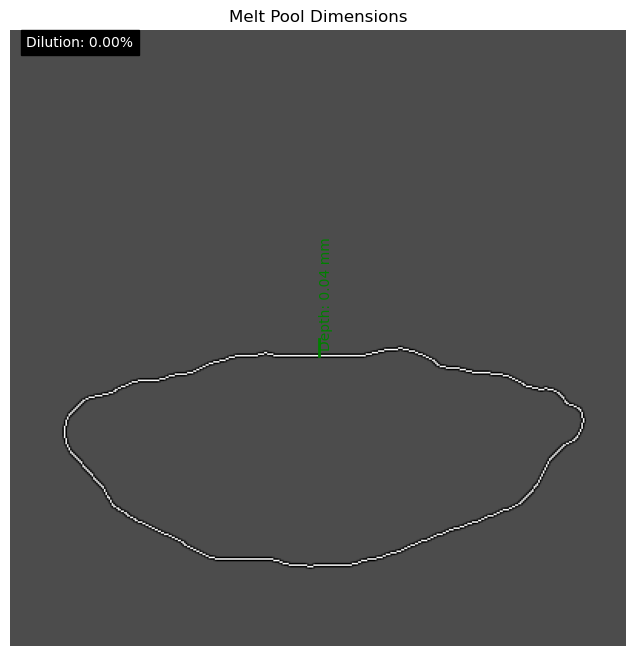

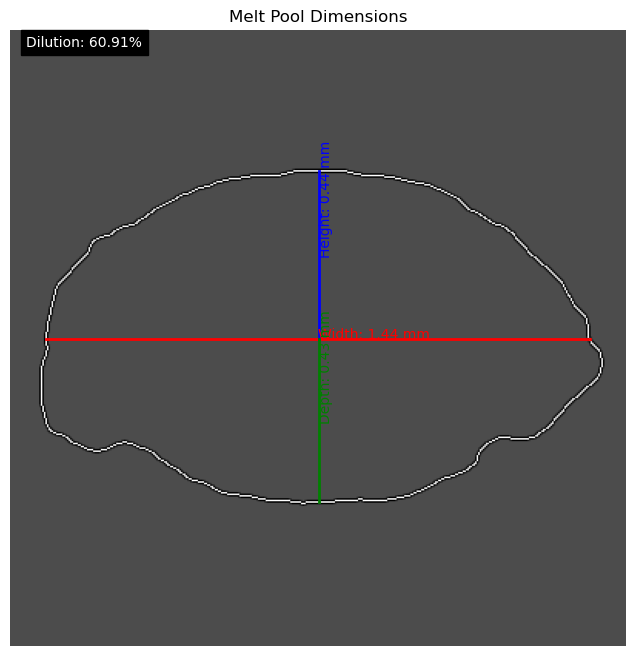

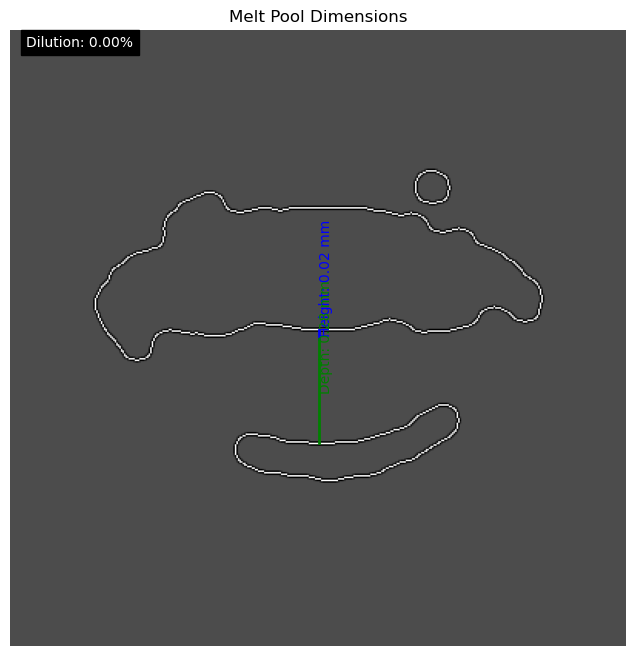

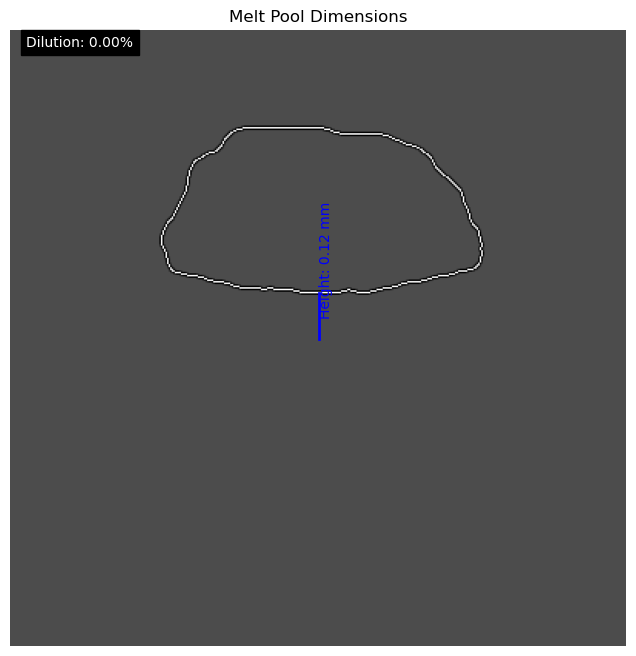

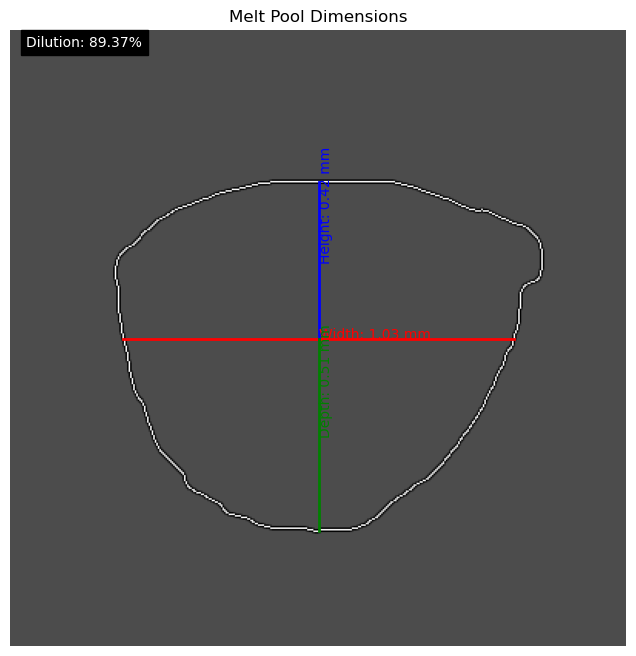

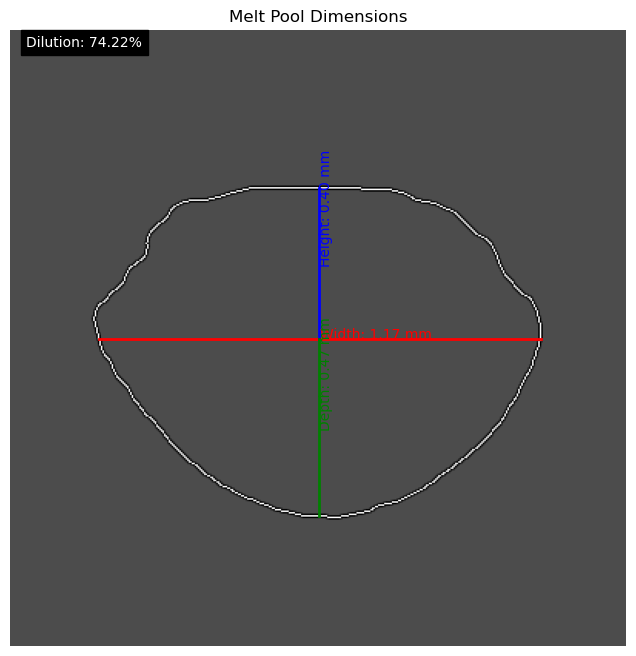

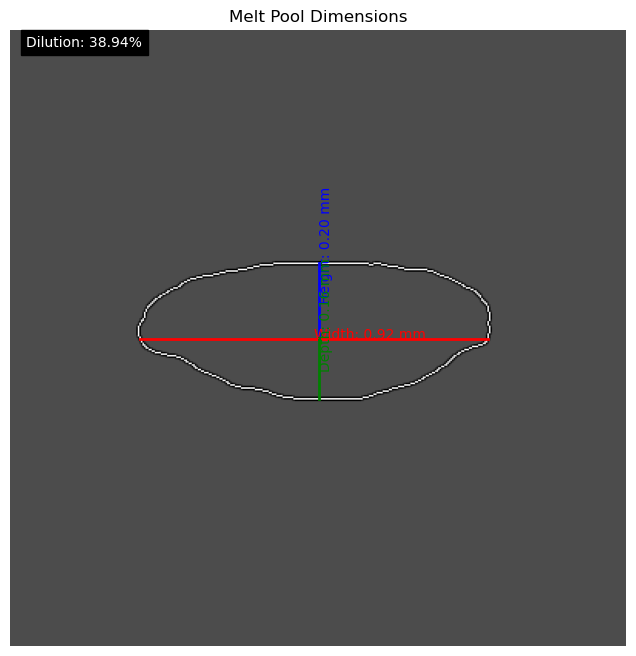

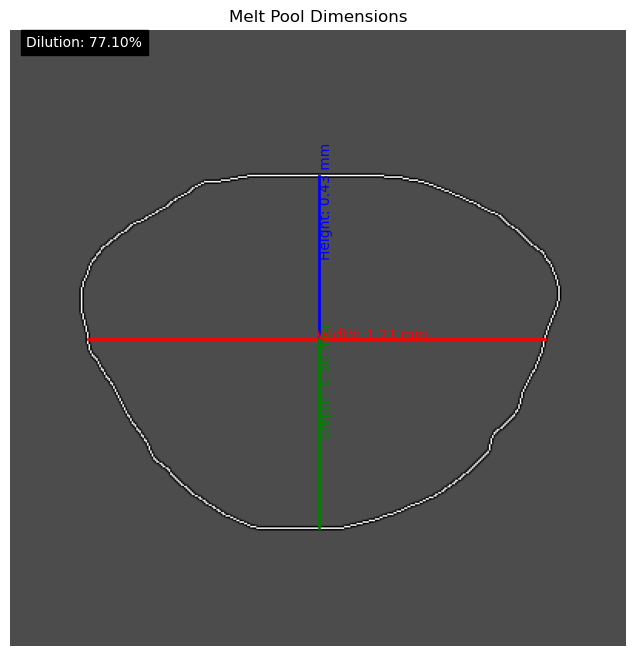

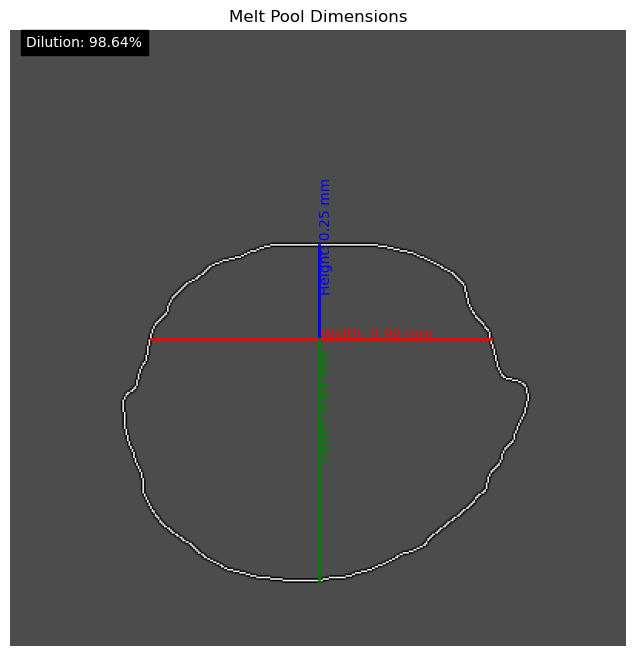

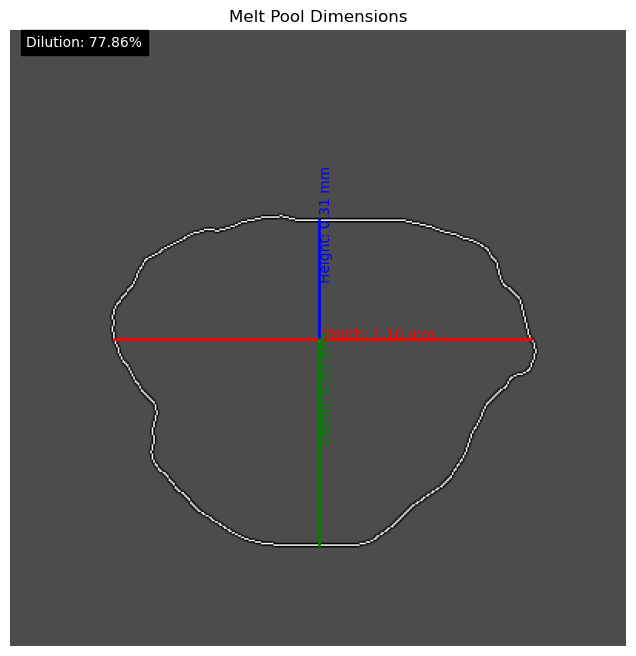

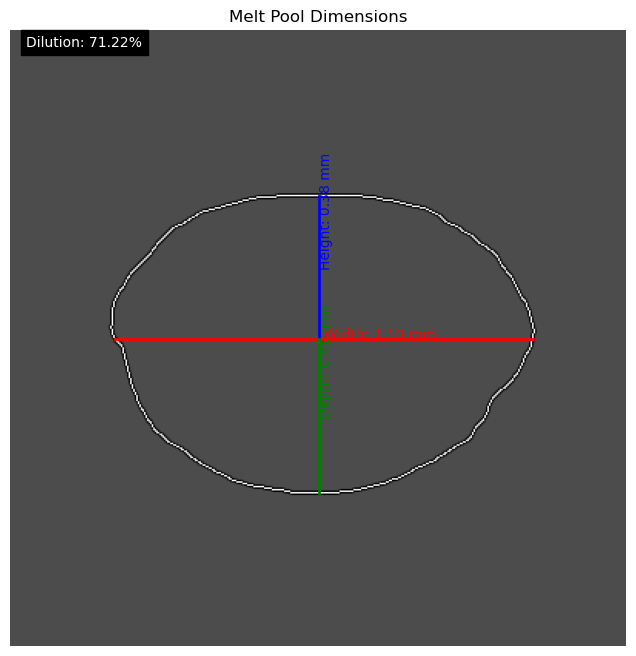

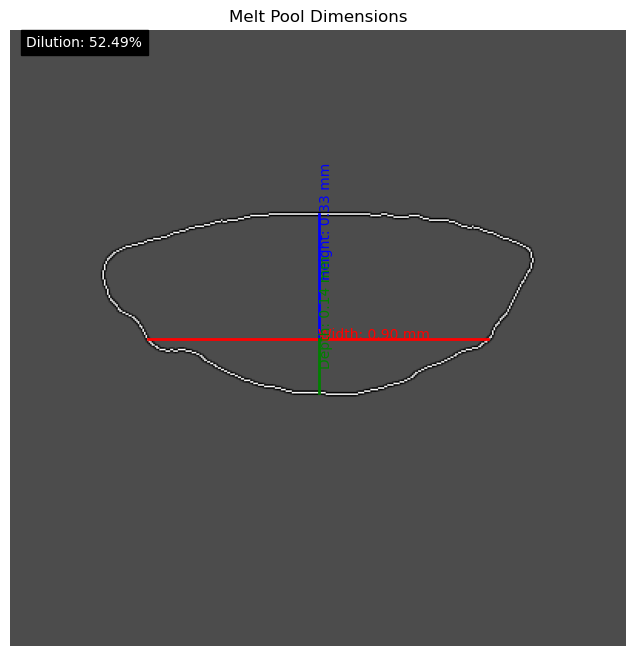

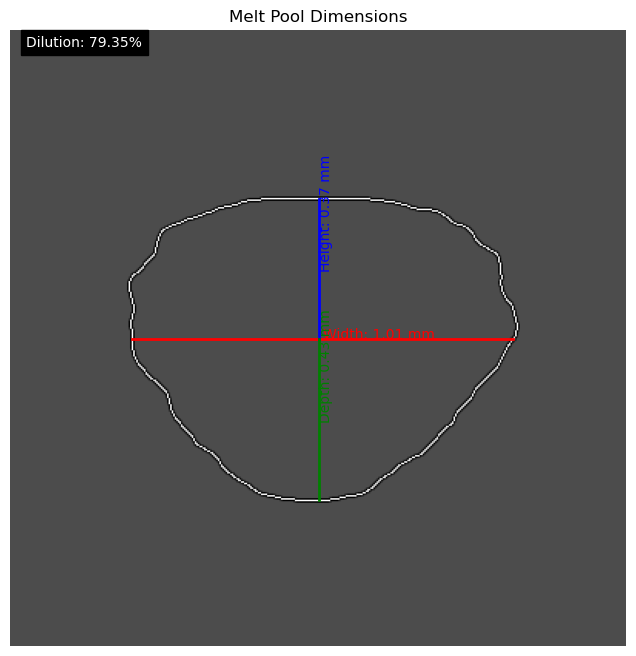

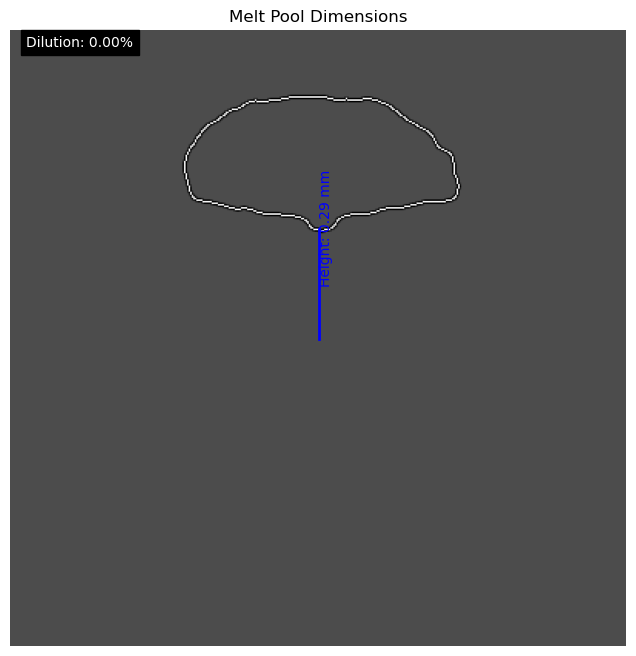

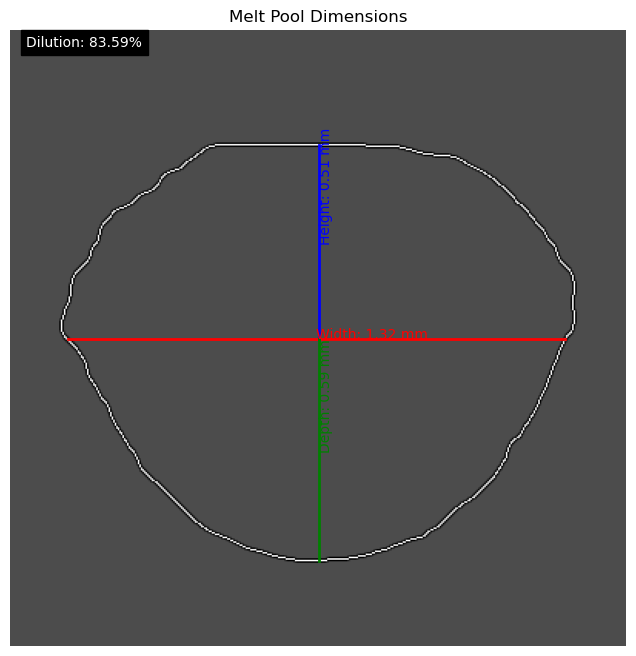

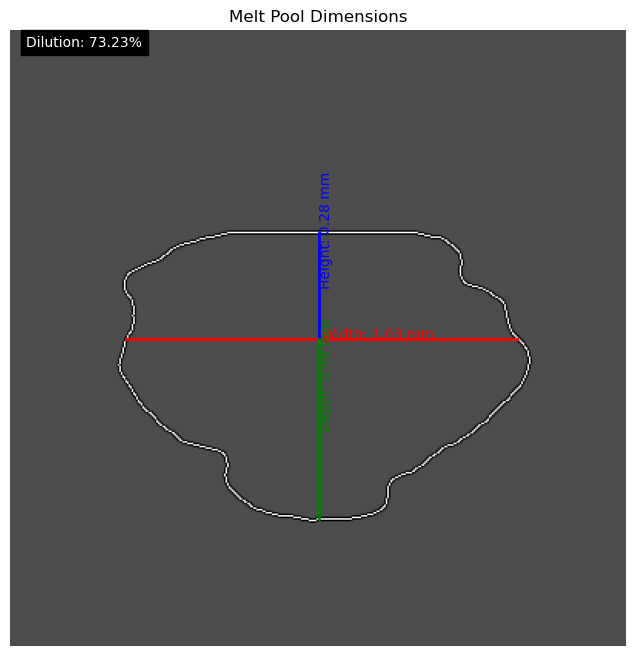

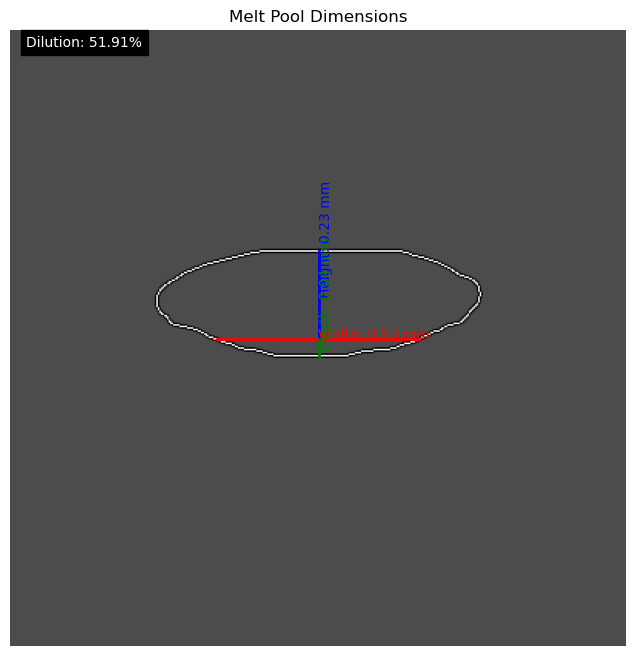

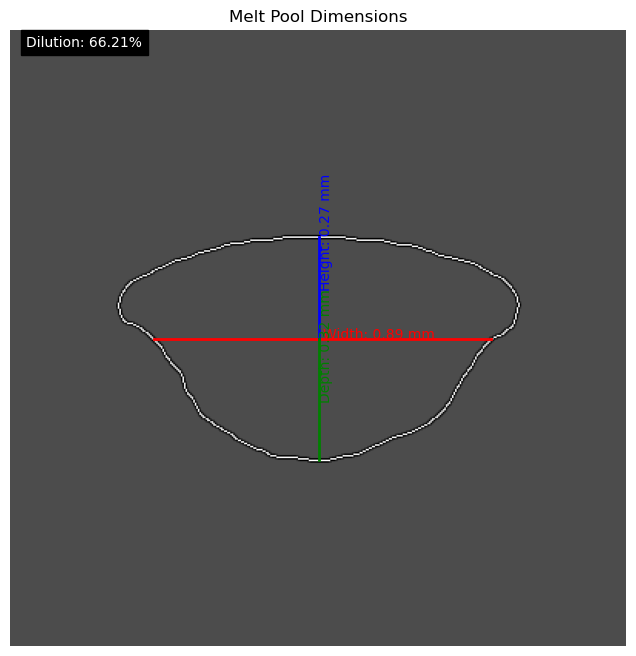

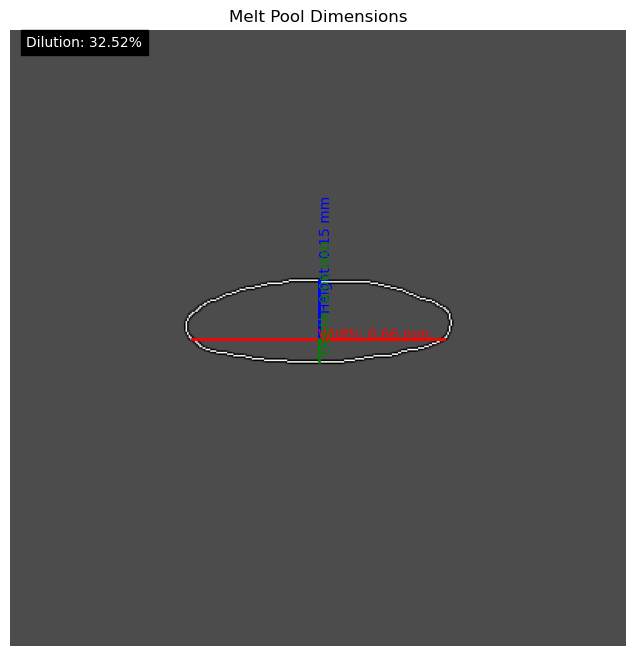

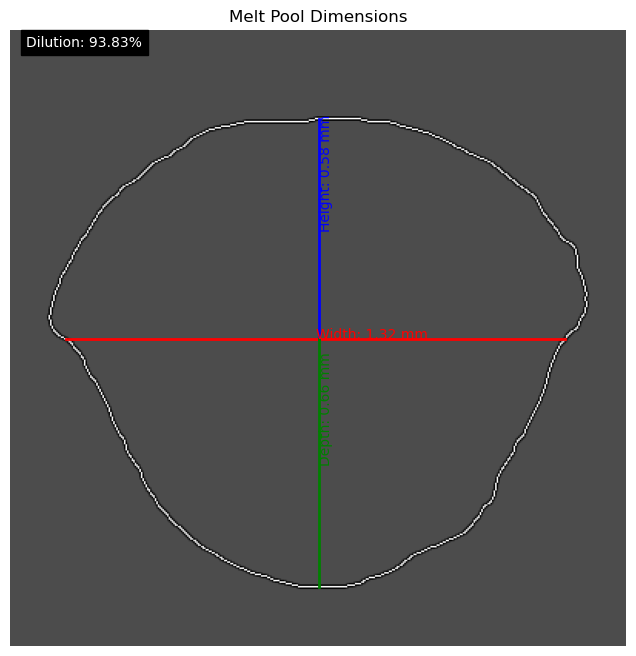

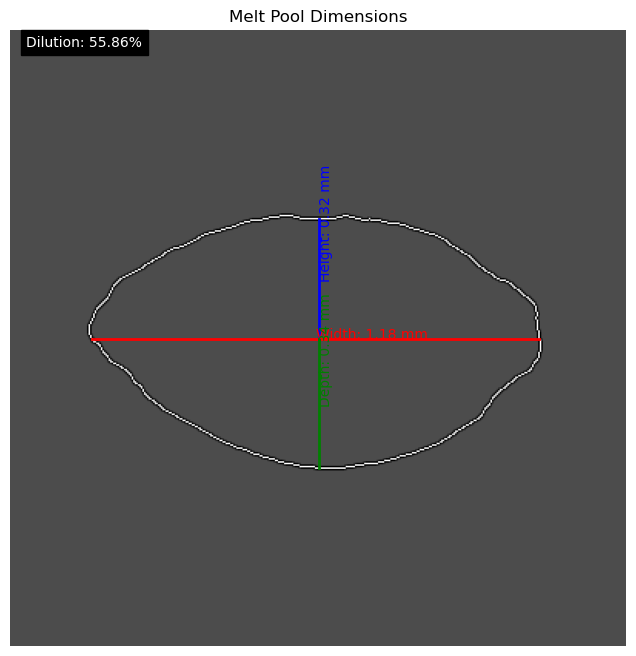

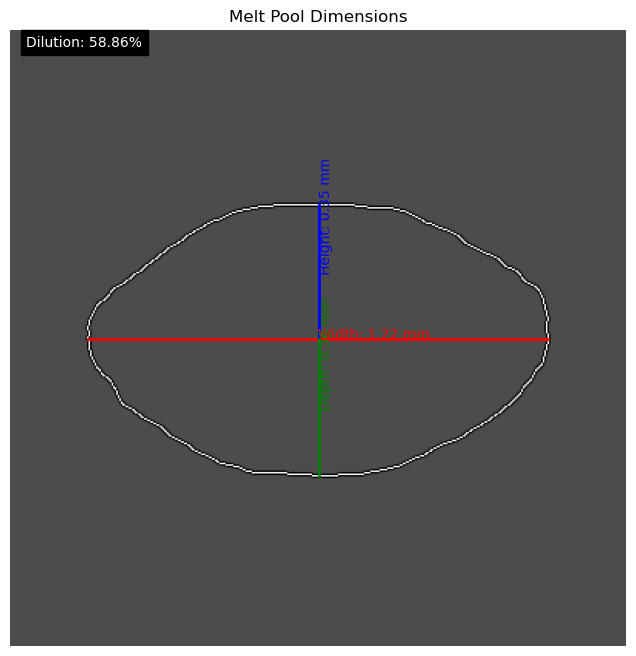

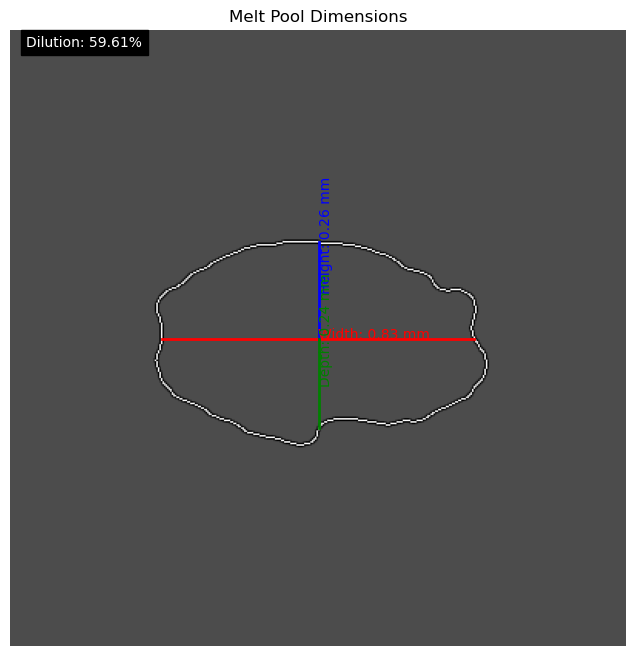

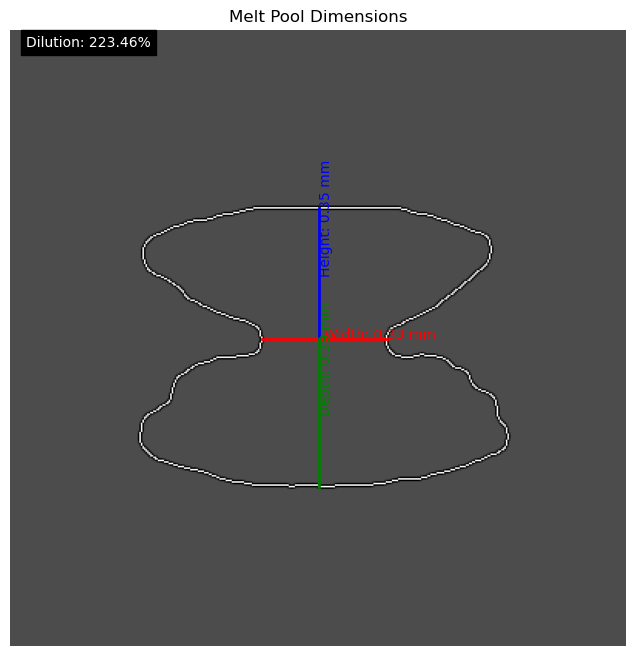

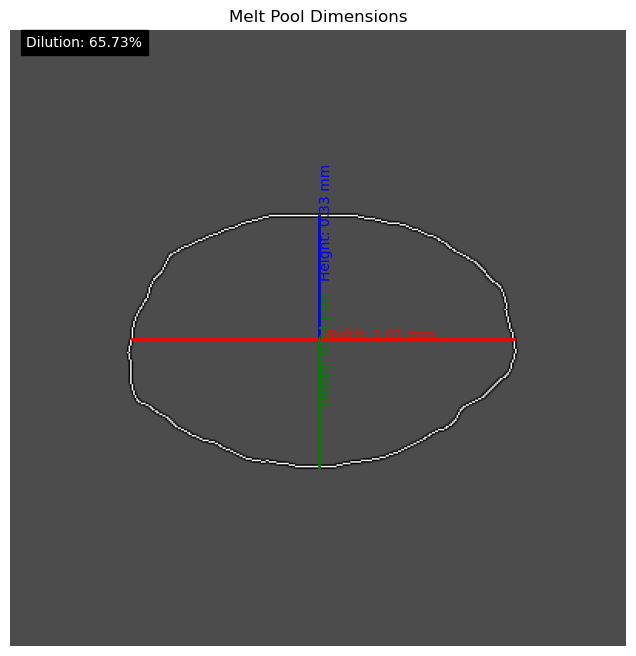

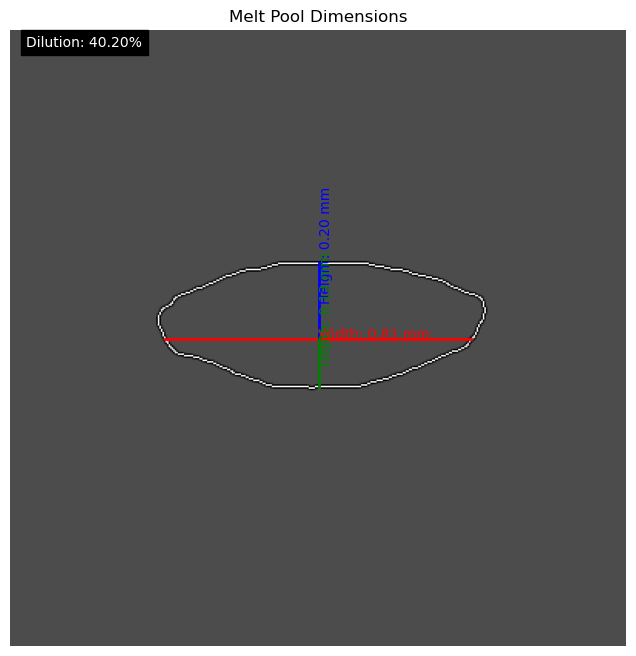

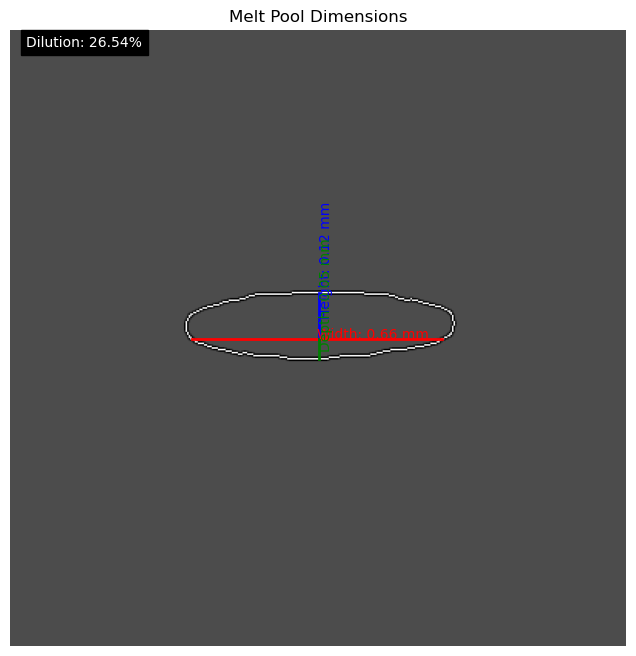

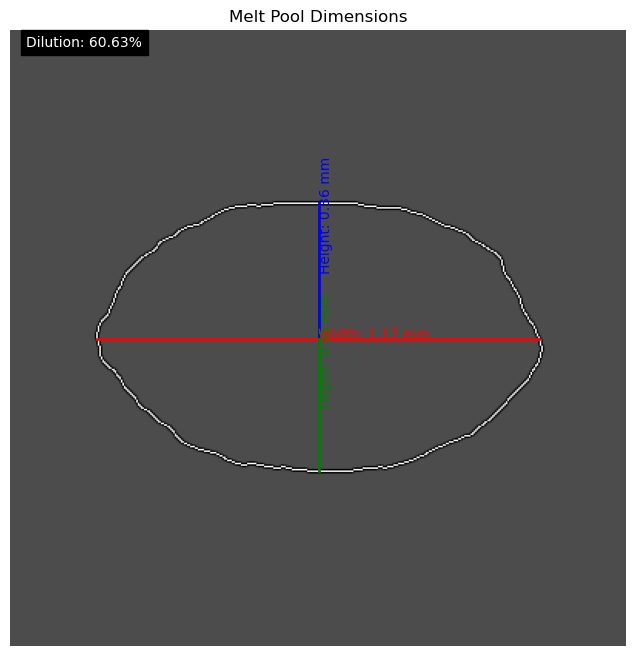

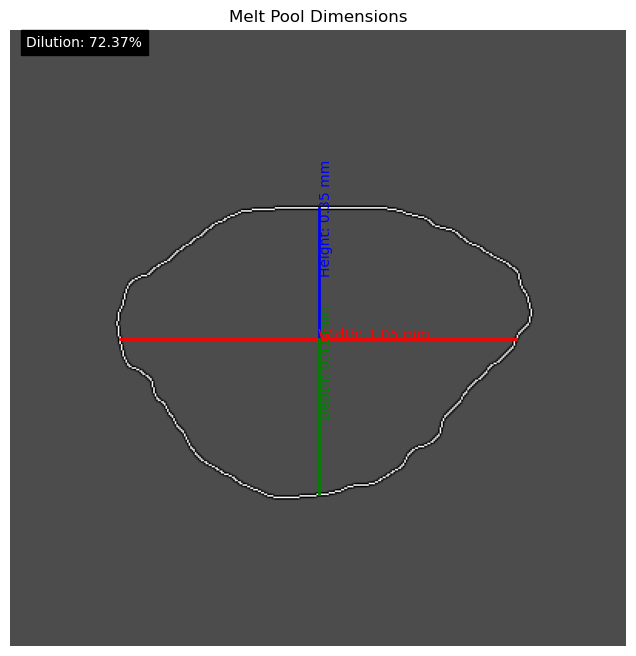

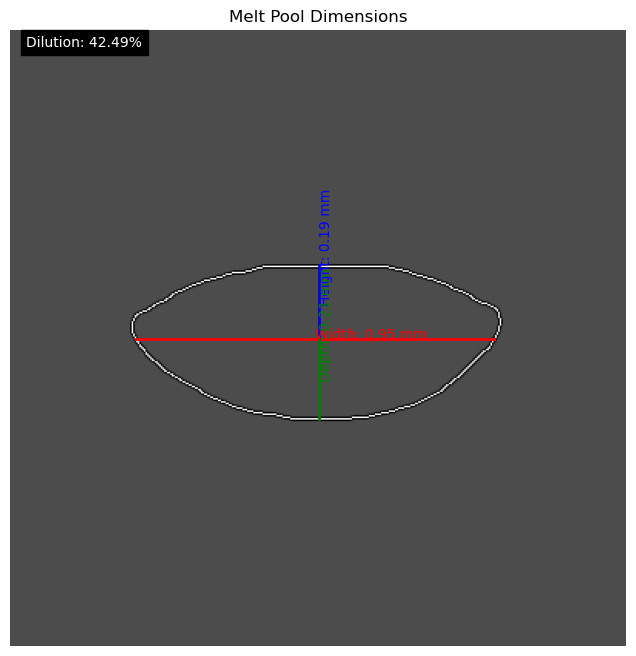

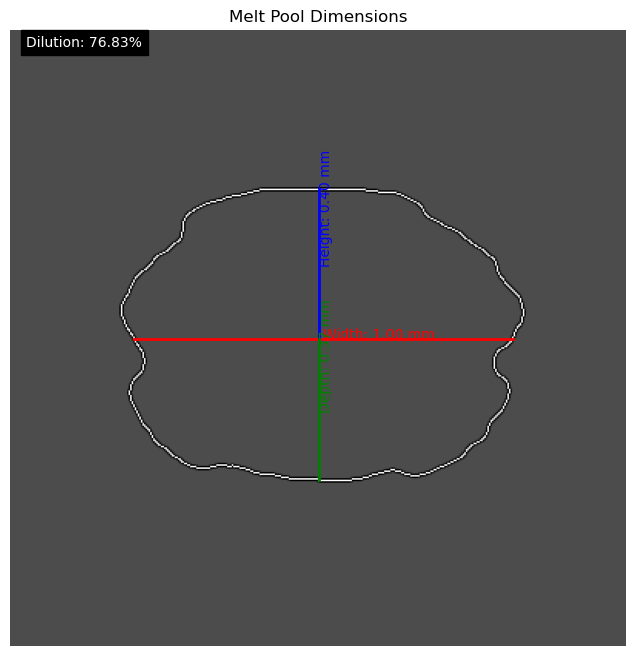

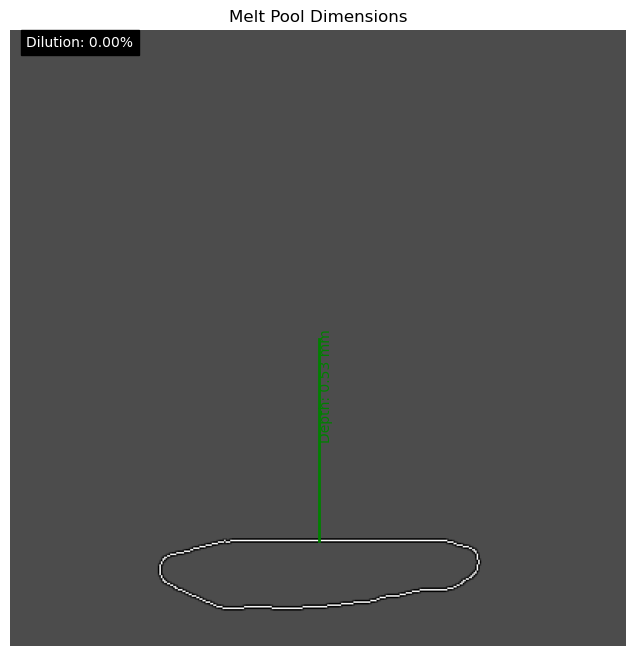

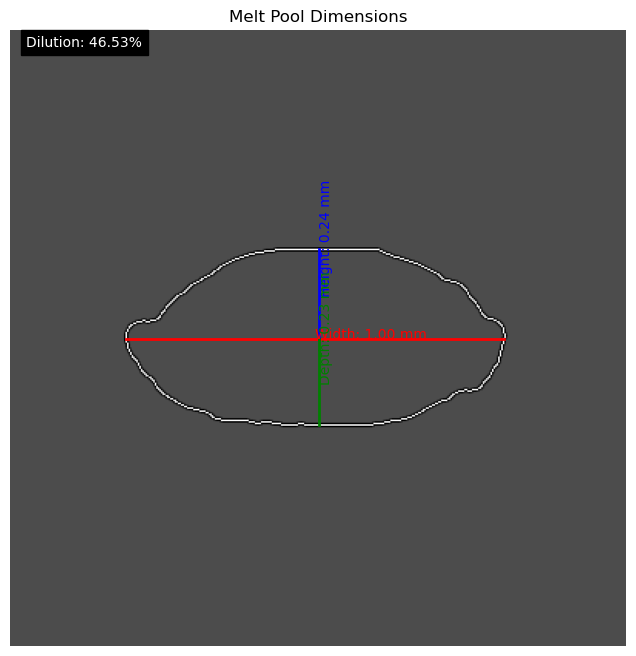

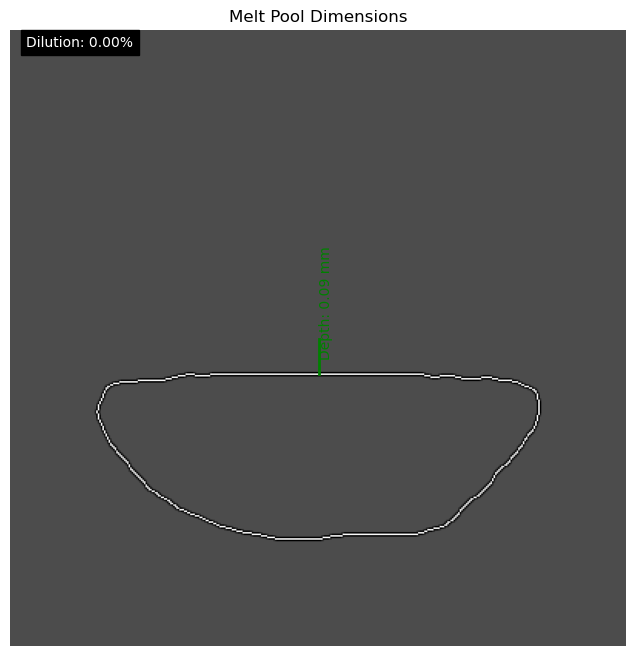

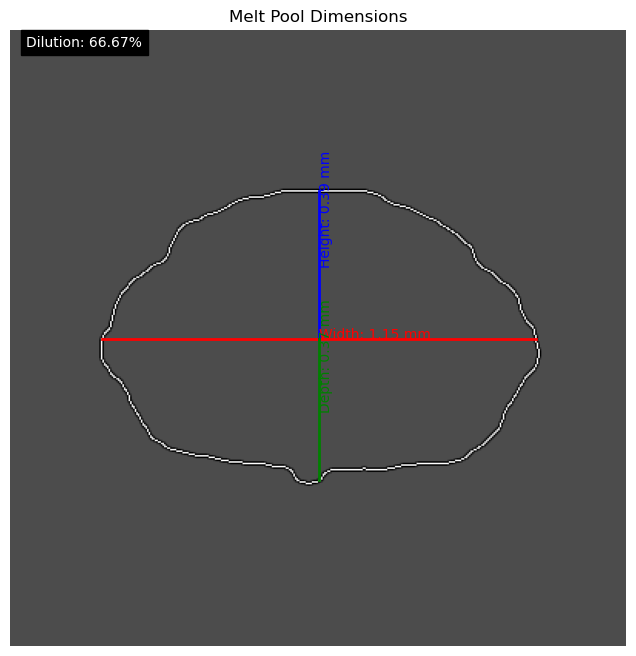

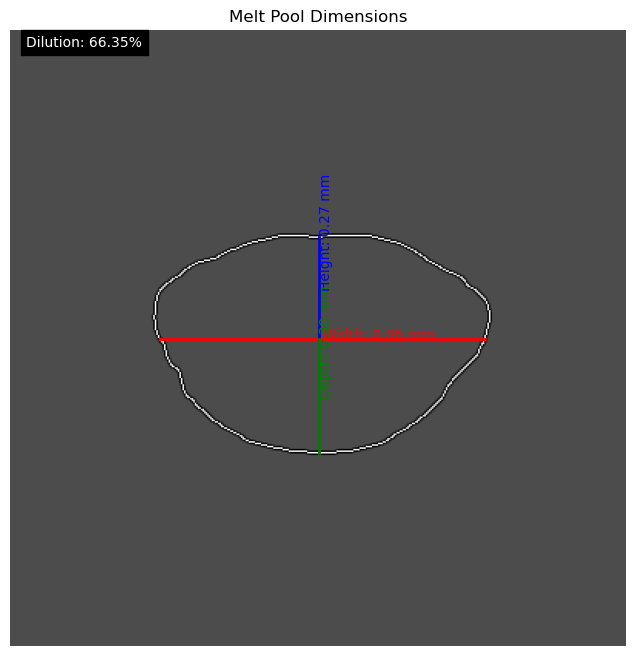

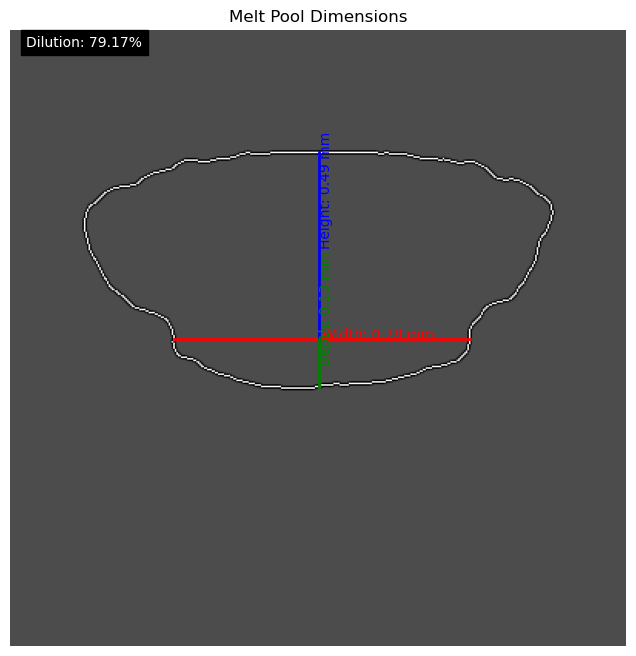

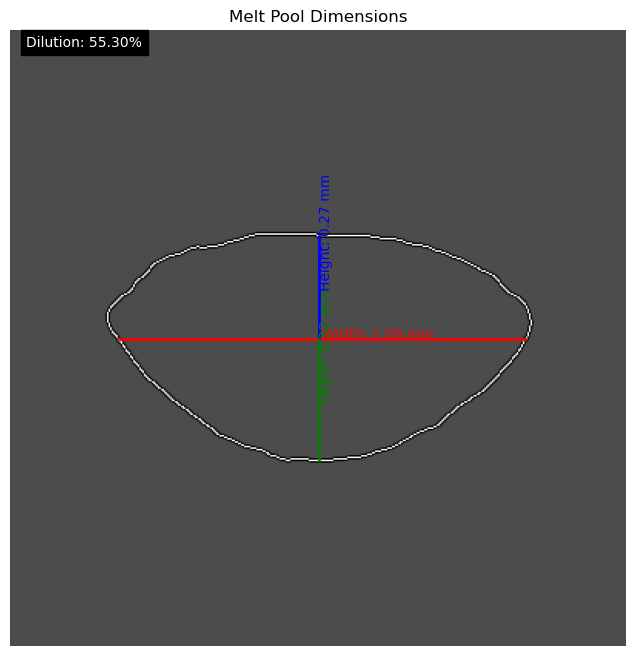

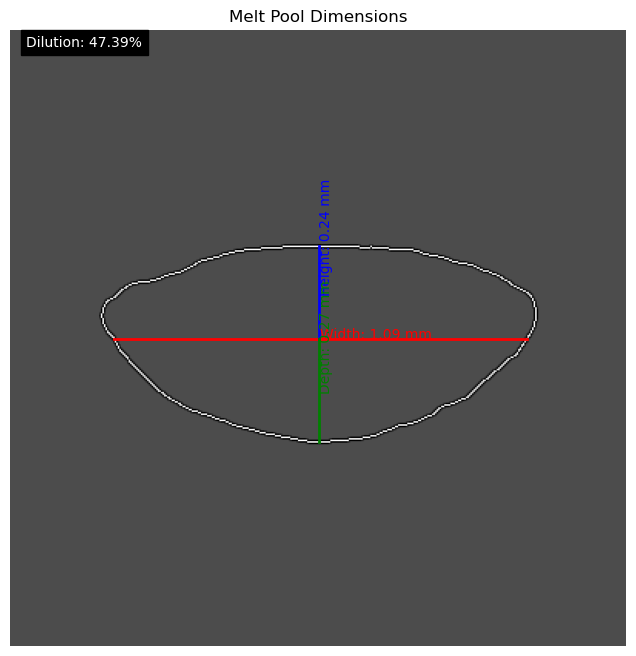

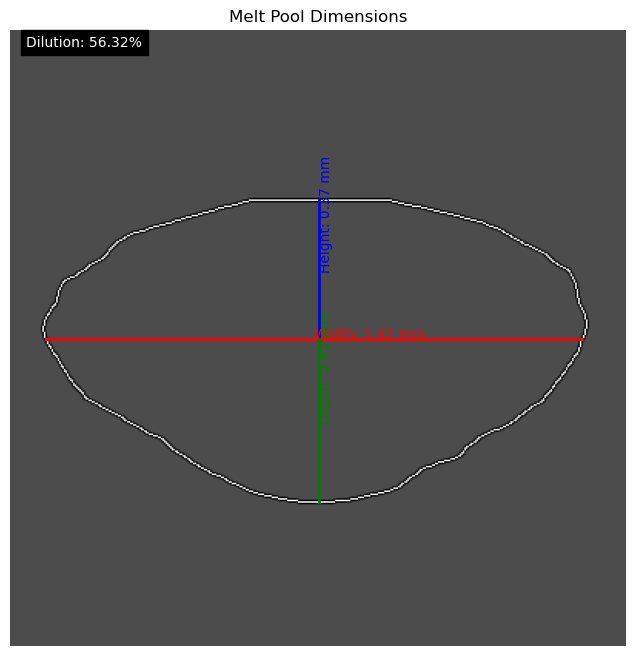

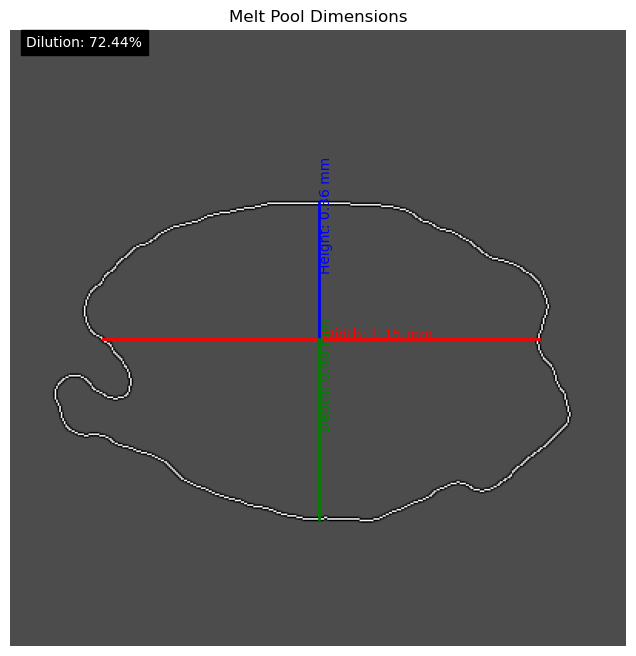

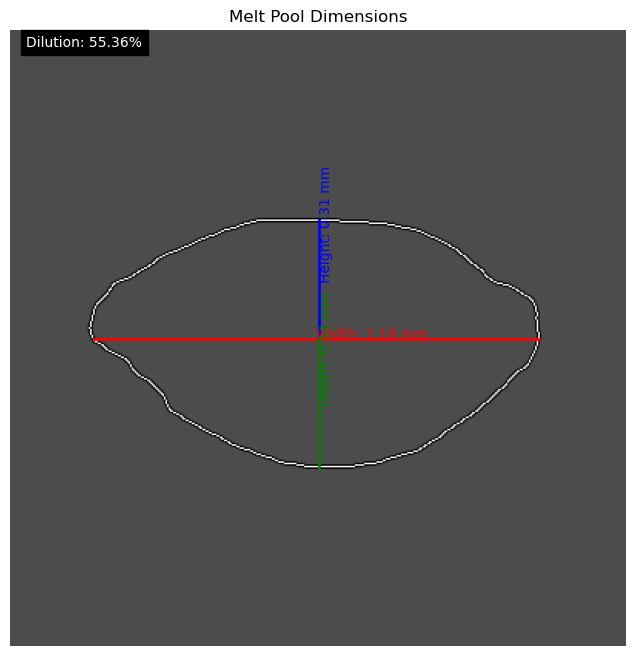

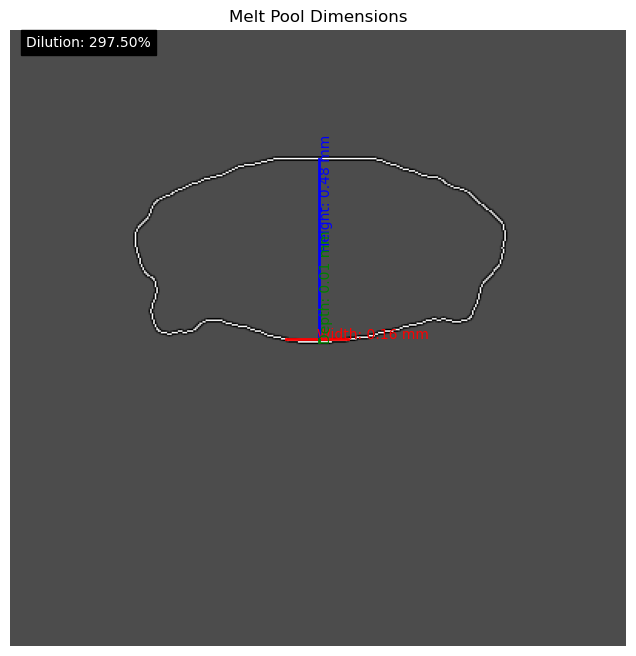

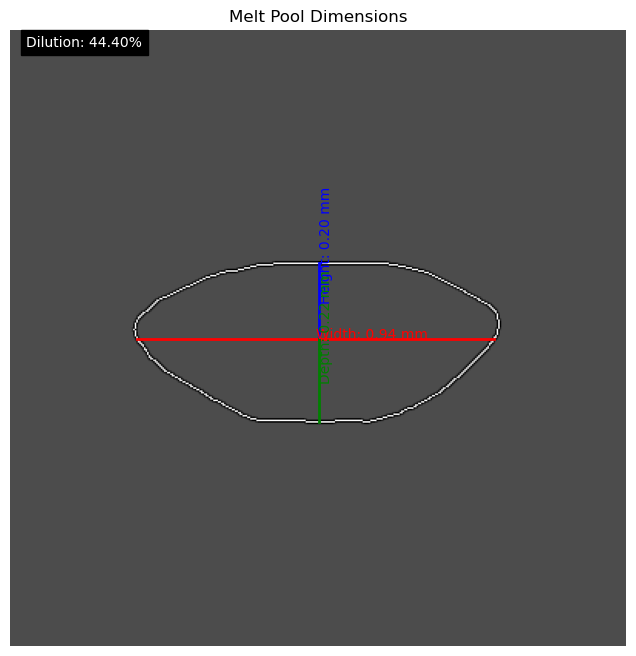

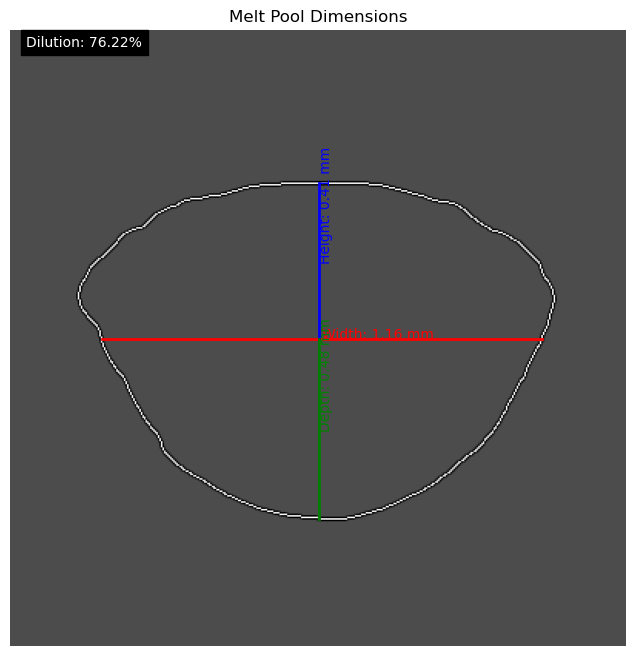

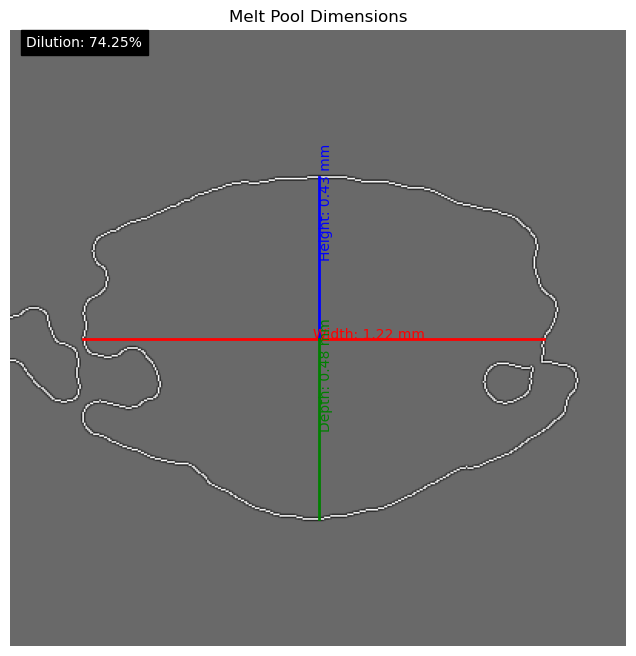

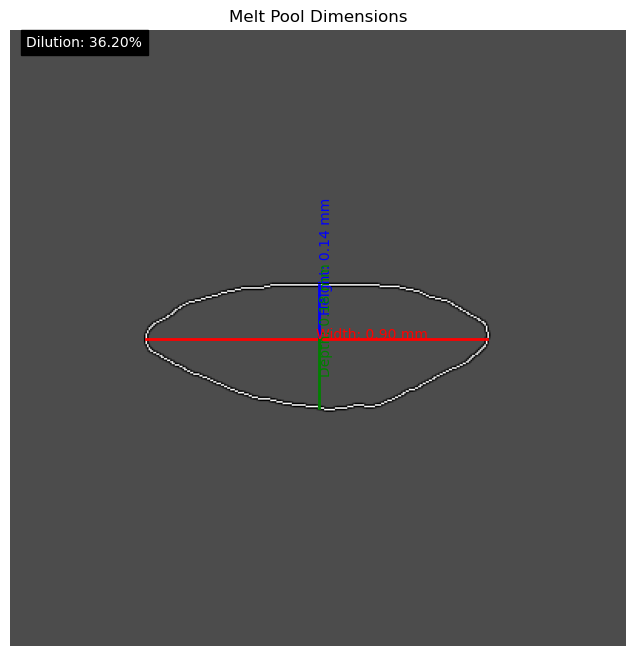

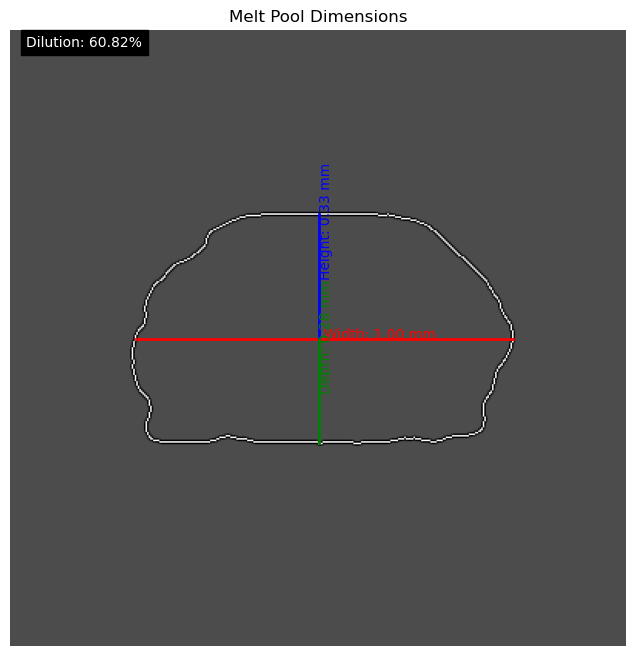

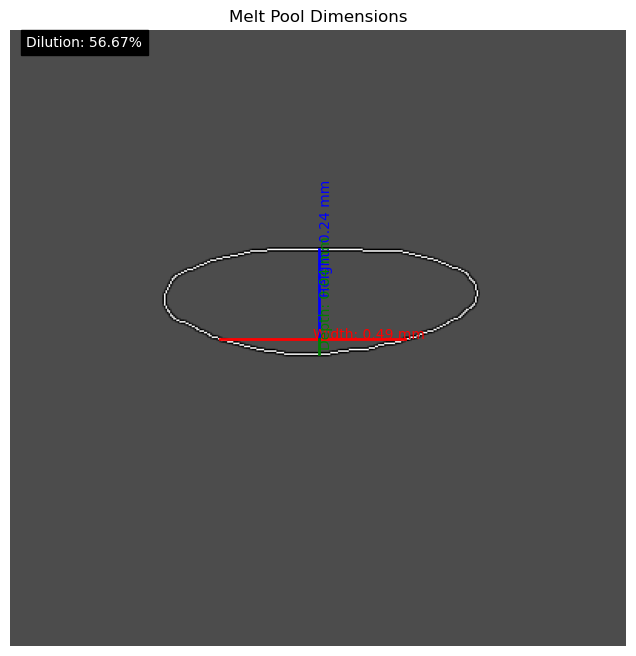

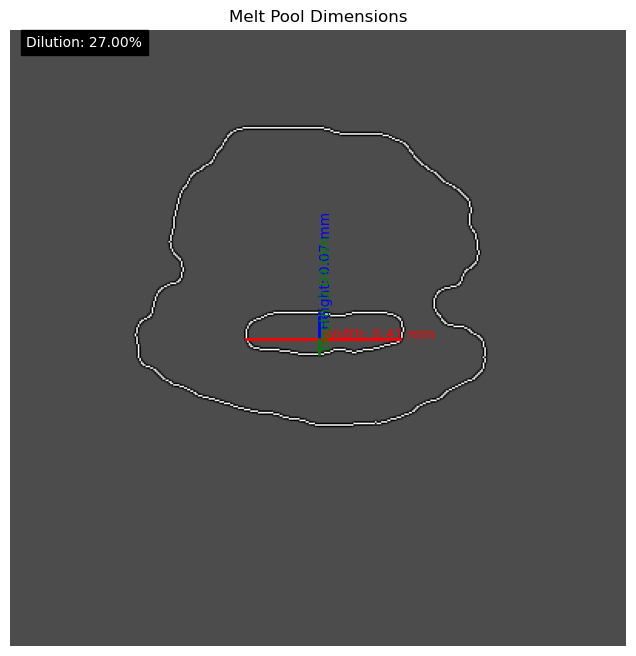

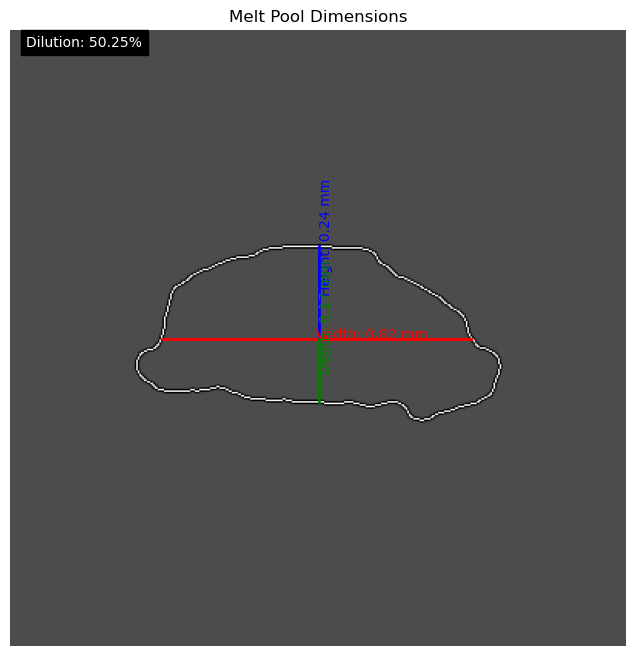

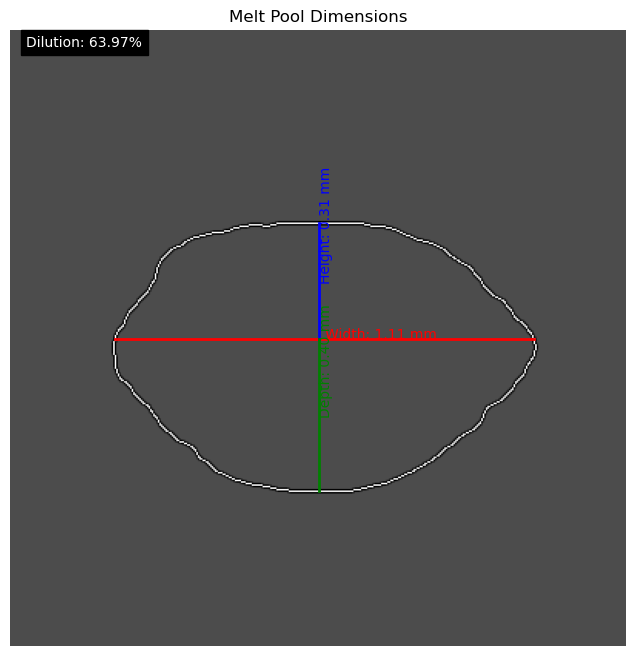

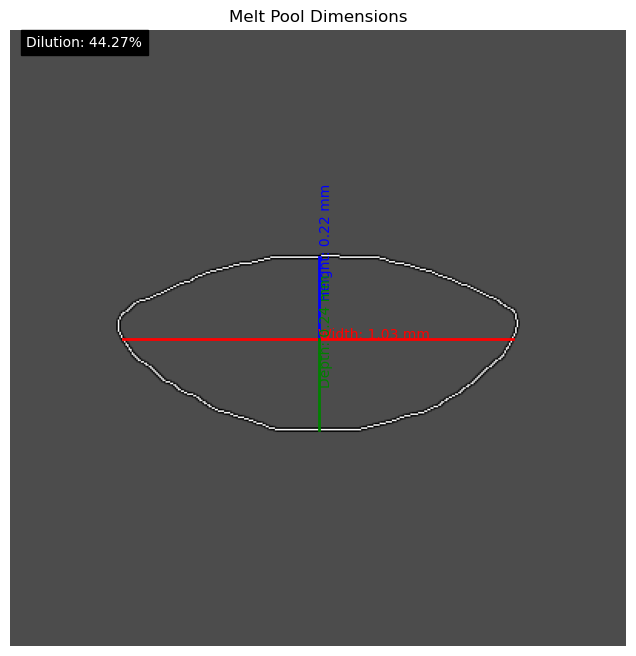

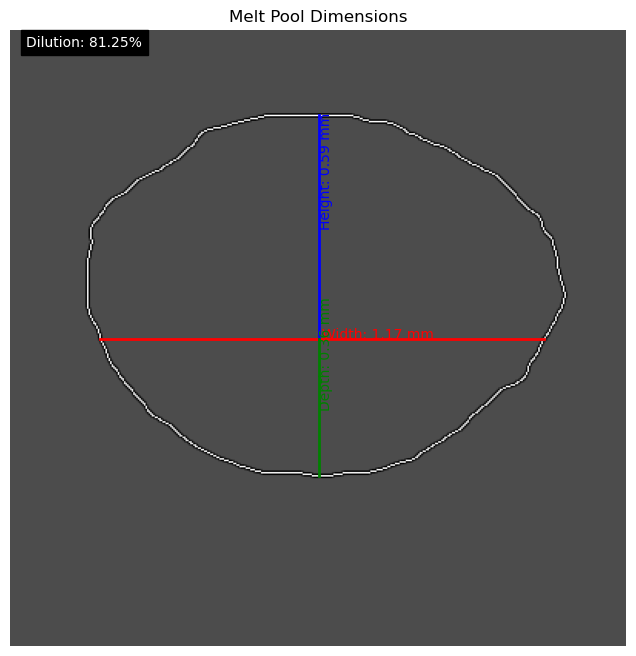

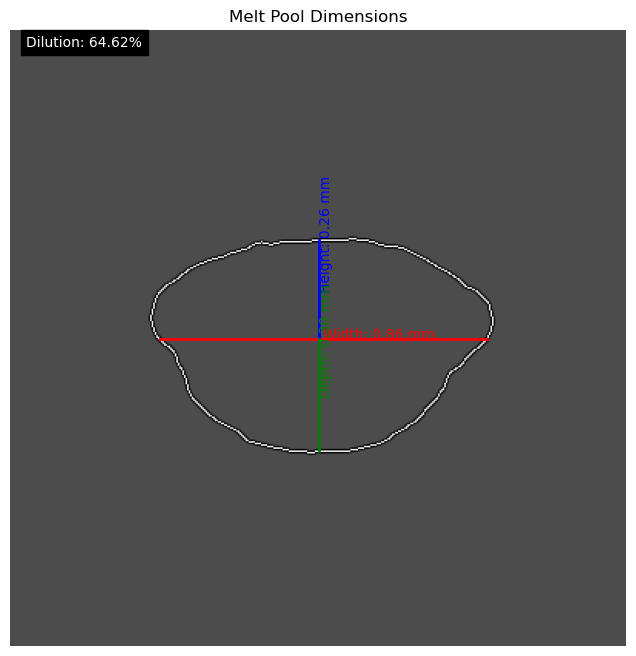

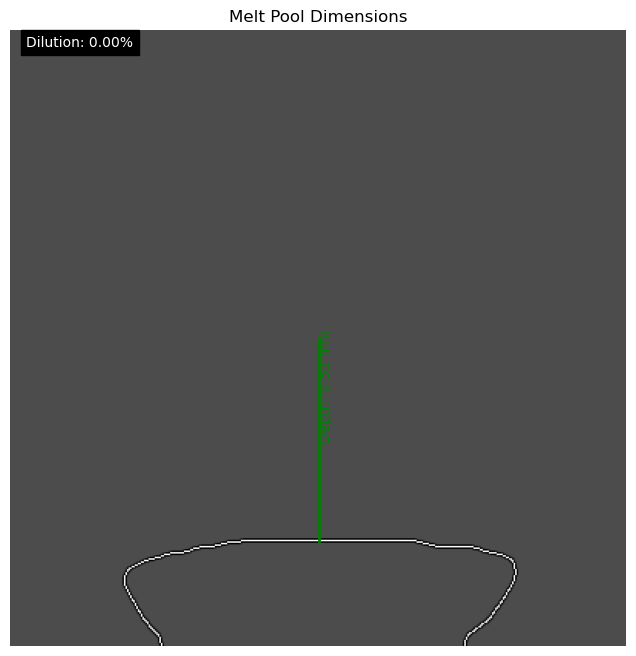

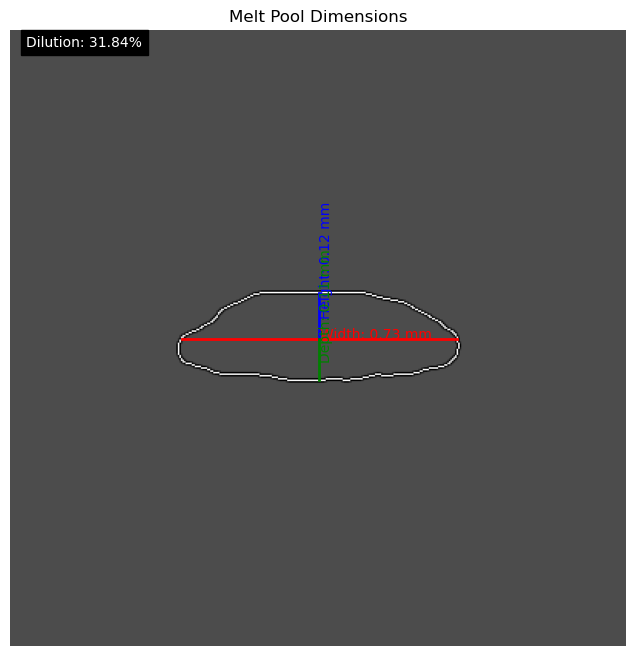

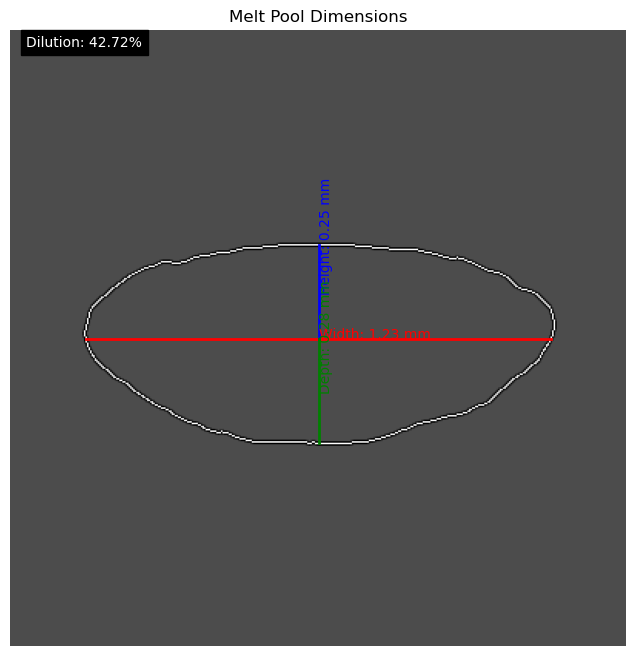

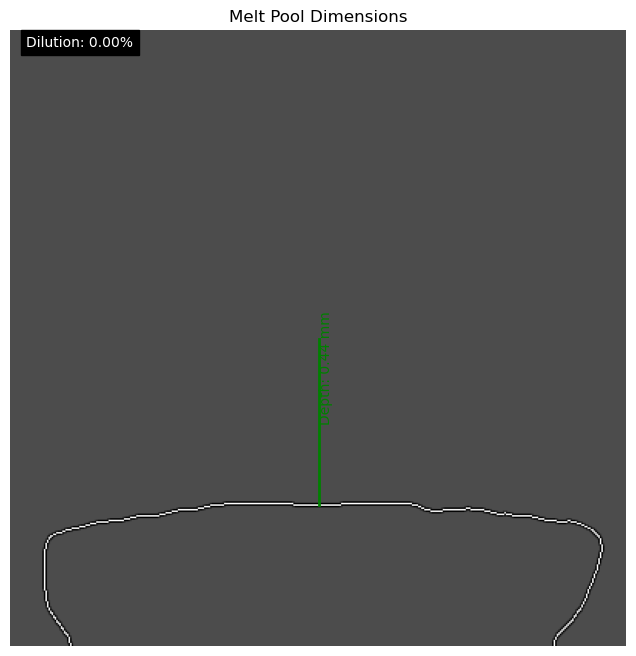

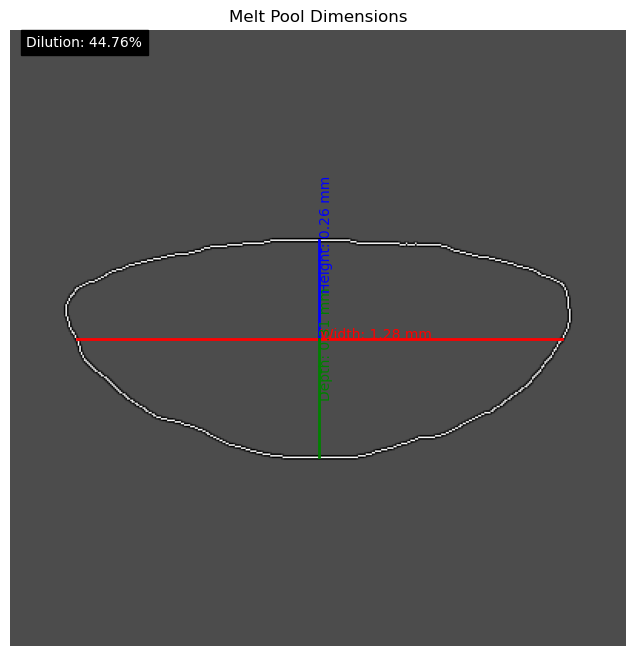

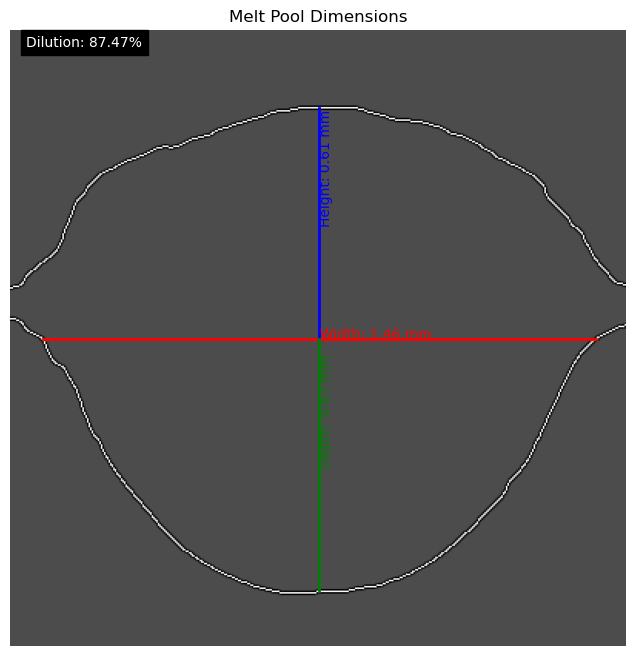

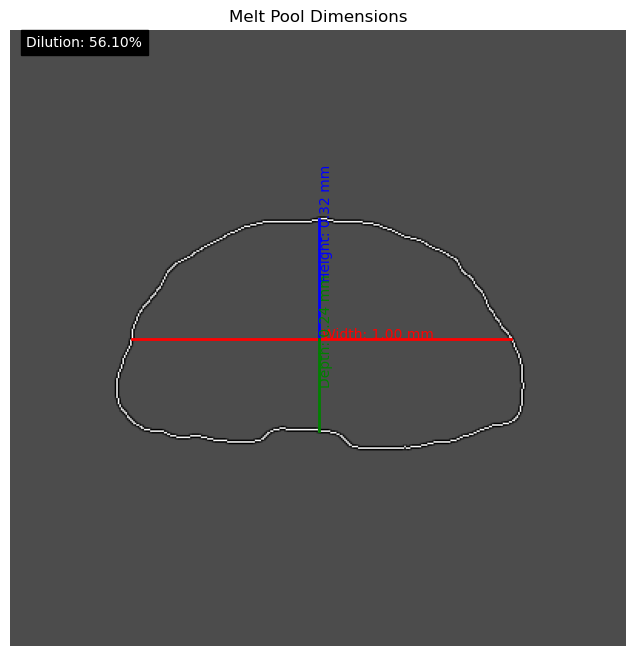

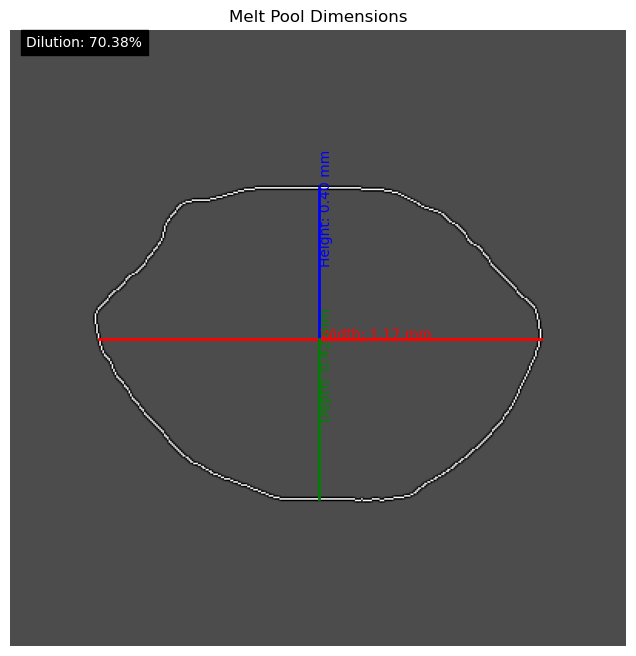

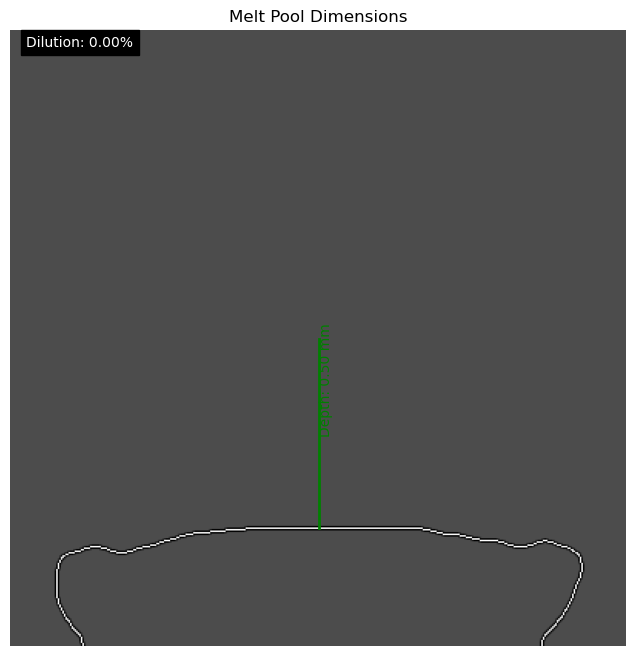

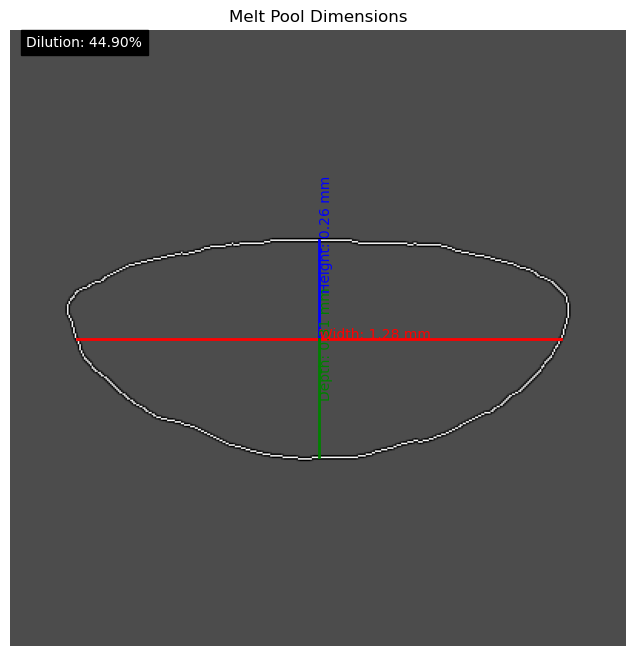

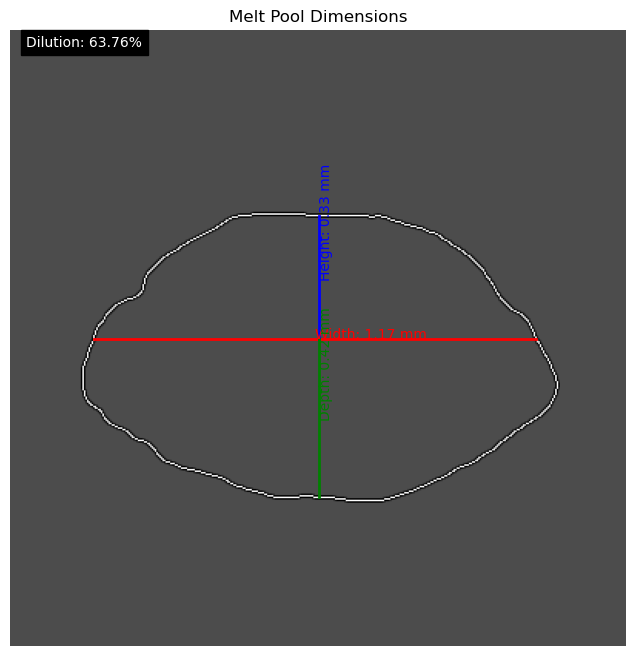

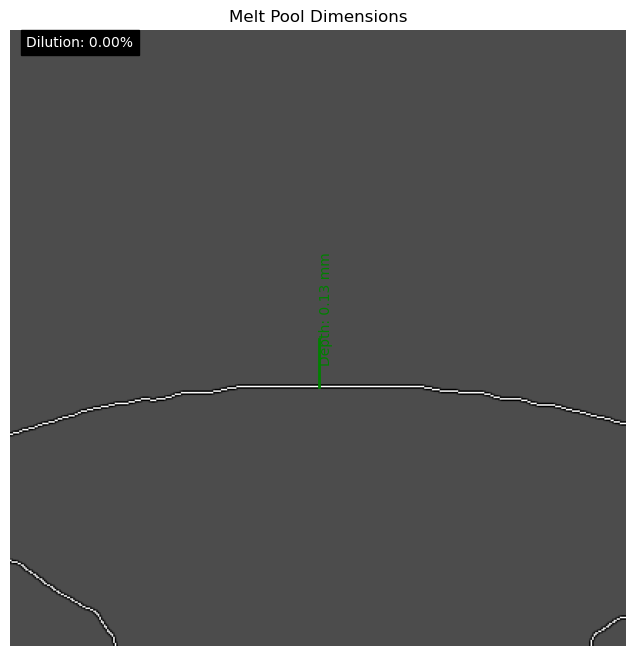

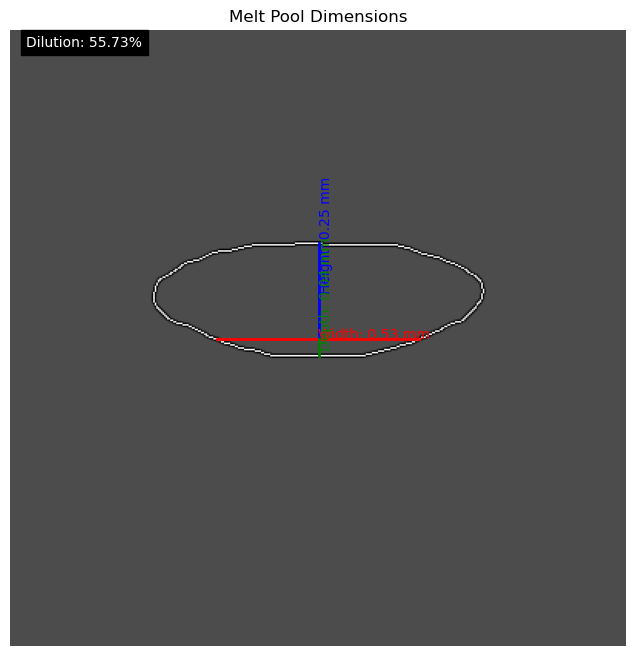

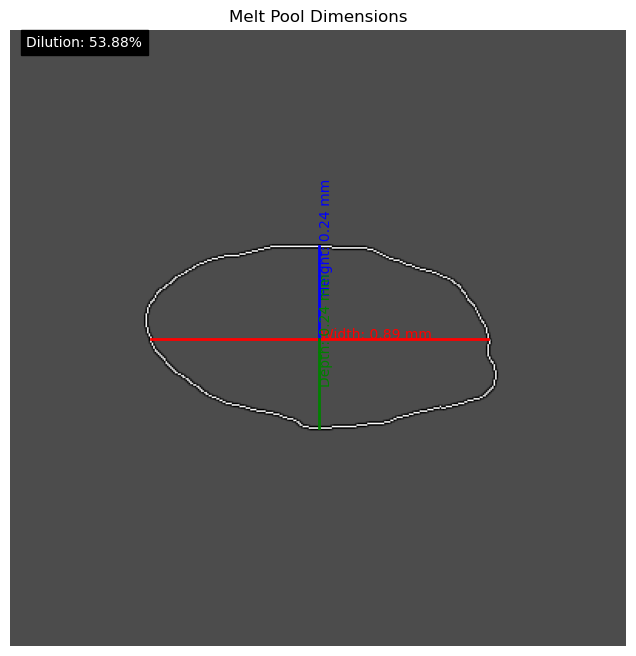

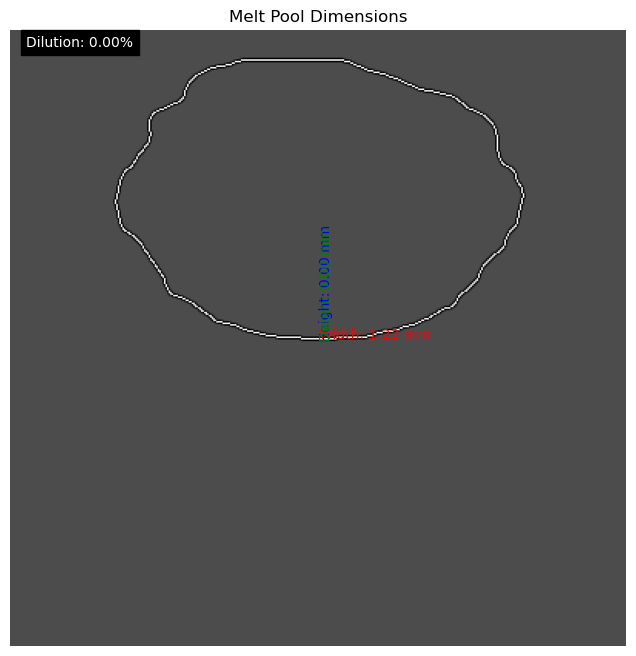

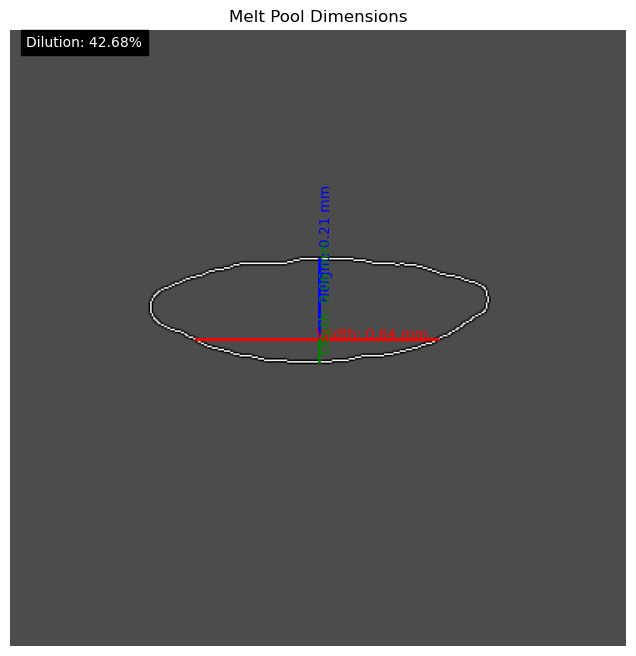

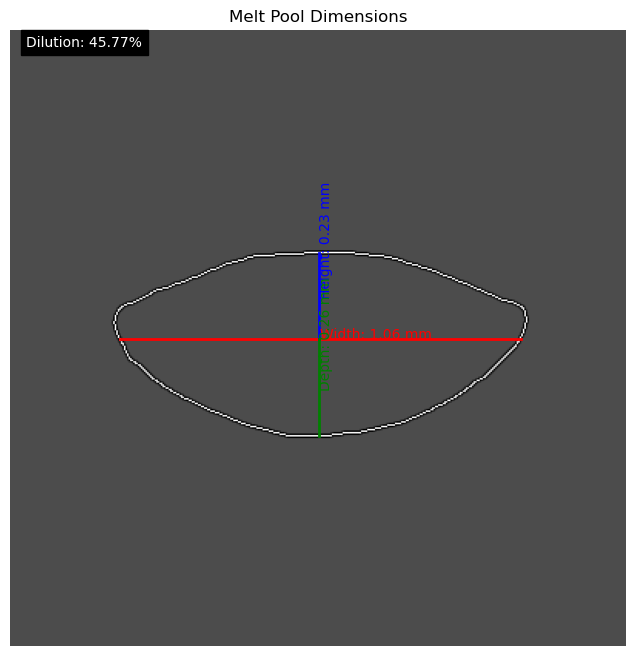

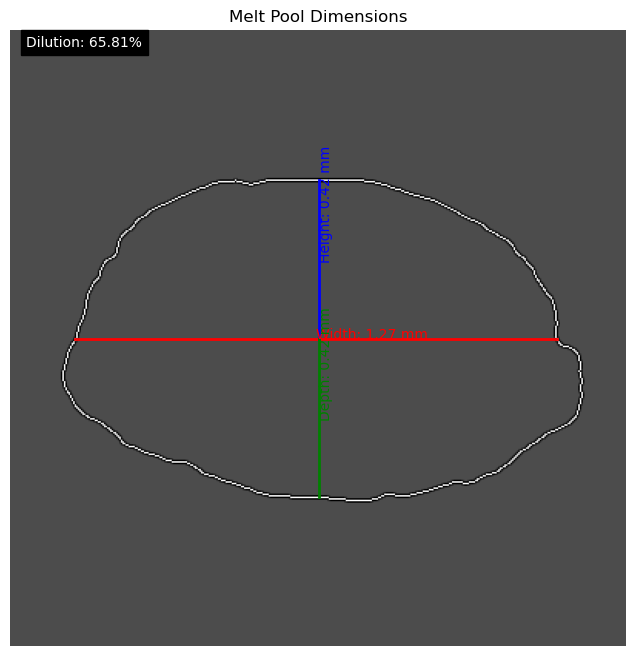

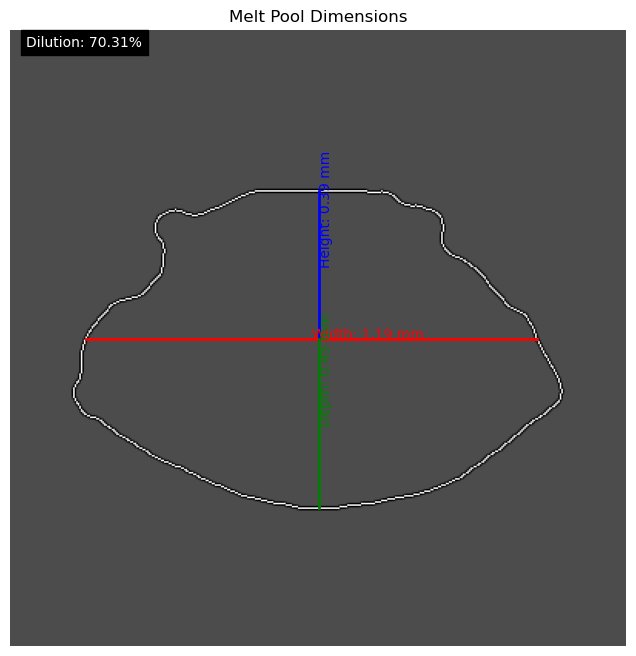

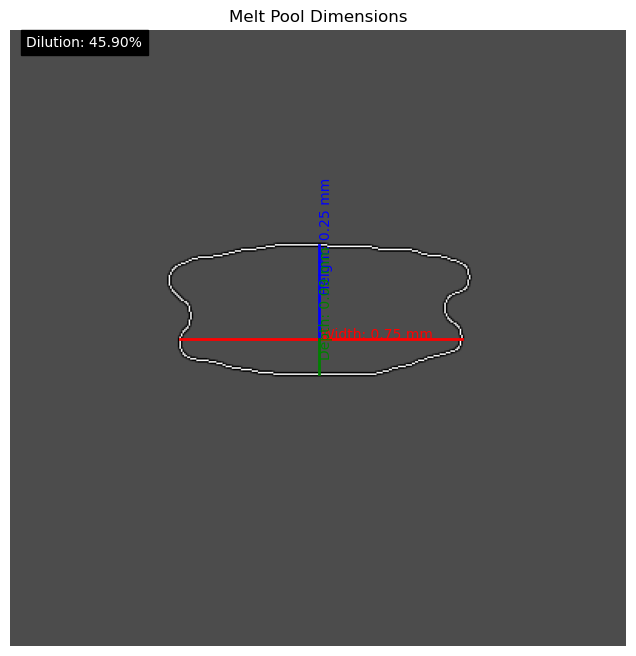

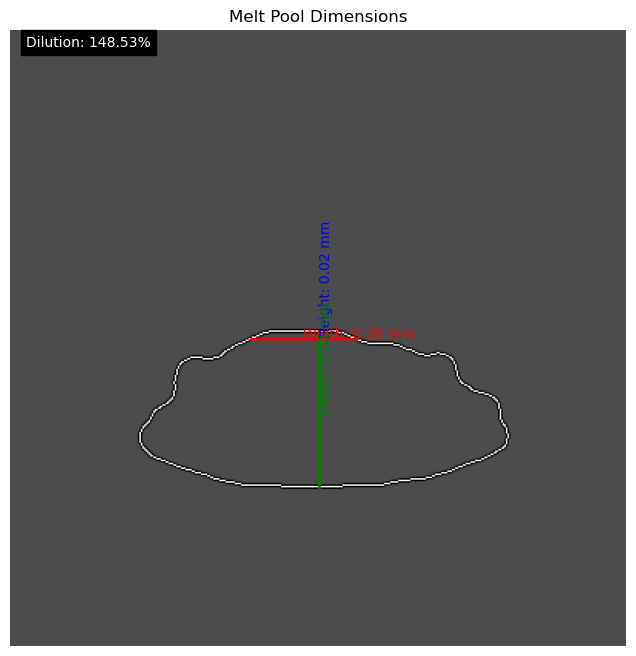

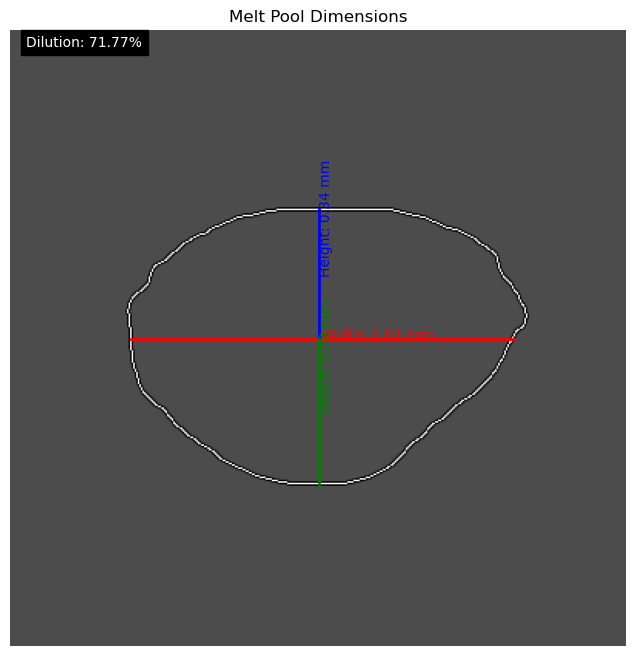

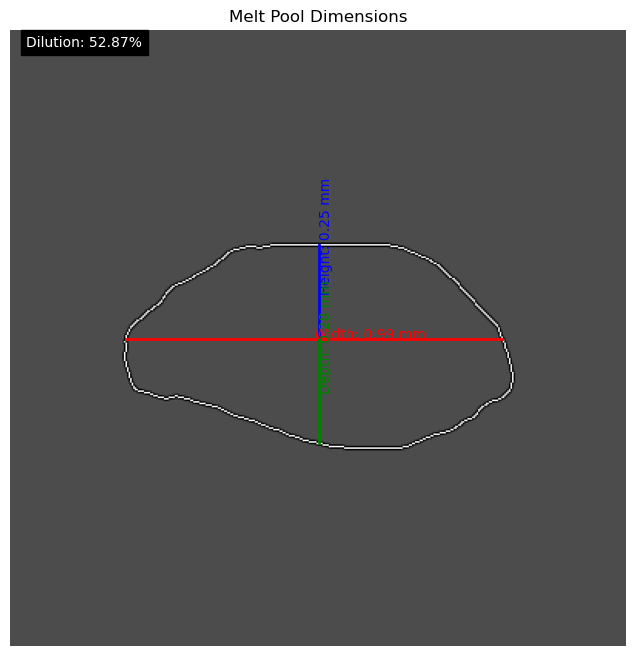

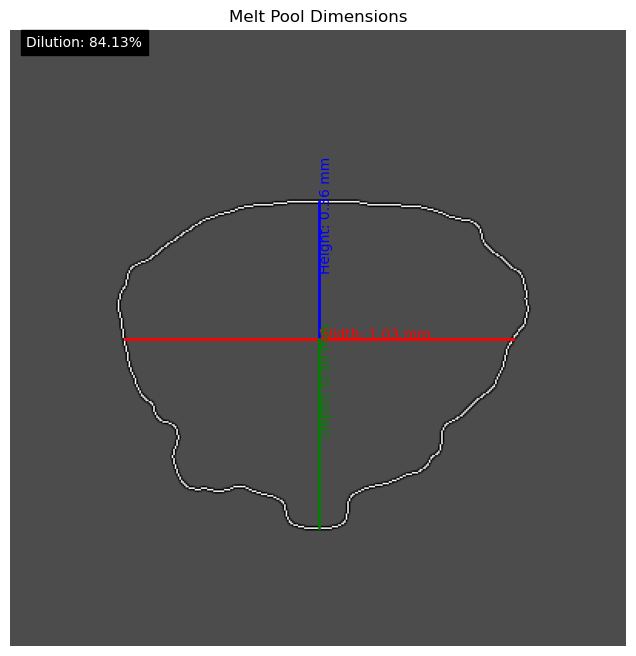

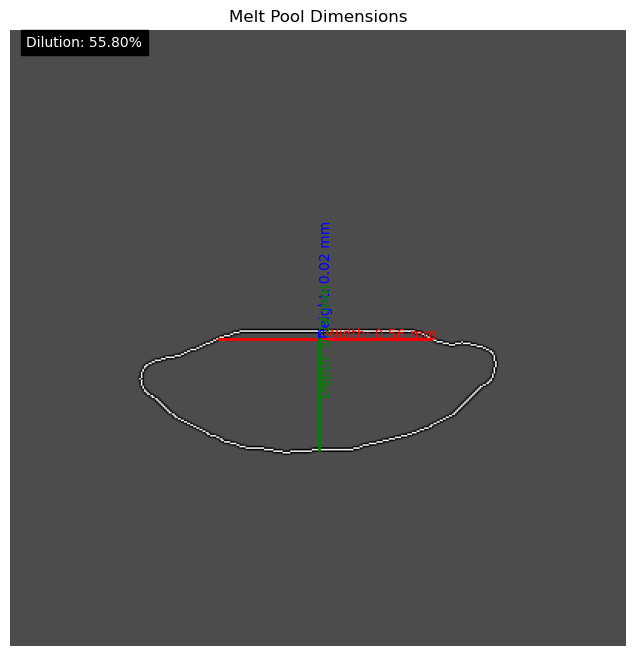

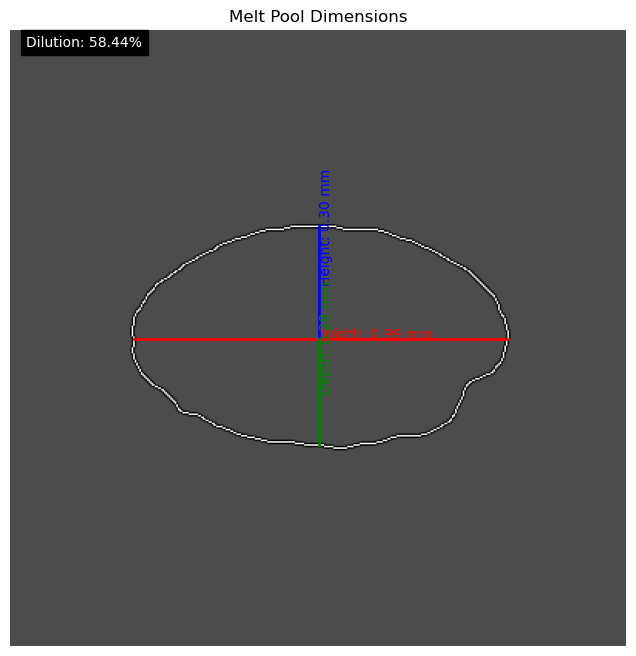

In [113]:
#the ouputs of the mp_pred function are width, height, depth, dilution, mp_contour, mp_contour_bi, We only need the width and height for now. Predict the width and height for each sample in the dataframe, where the inputs are the power, scan speed, and hatch spacing.

#add columns to the dataframe for width and height
X_test_new['Width'] = 0
X_test_new['Height'] = 0

#create a folder to save the contour images
os.mkdir('contour_images')

#loop through each row in the dataframe
for i in range(len(X_test_new)):
    #predict the width and height for each sample TH_Co,TH_DF,S_H,D,
        
    pred = process_and_visualize(X_test_new['Power'][i],X_test_new['Scanning_Speed'][i],X_test_new['RPM'][i] ,X_test_new['Thermal Conductivity'][i] ,X_test_new['Thermal Diffusivity'][i],X_test_new['Specific Heat'][i],X_test_new['Density'][i])

    #add the width and height to the dataframe
    #Note: 4.97 used to correlate image mask to pixels 
    #Note: 0.0039957 used to correlate image pixels to mm 
    #save the contour image to the contour_images folder
    #save the image from the process_and_visualize function to the contour_images folder with the name as the index of the row
    plt.savefig(f'contour_images/{i}.png')

    X_test_new['Width'][i] = pred[0]
    X_test_new['Height'][i] = pred[1]

In [119]:
y_test= pd.DataFrame(y_test)
y_test = y_test.rename(columns={0:'Mask_Array'})
y_test.head()

Mask_Array  1  2  3  4  5  6  7  8  9  ...  159990  159991  159992  159993  \
0           0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
1           0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
2           0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
3           0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
4           0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   

   159994  159995  159996  159997  159998  159999  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

[5 rows x 160000 columns]

/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/by/cl20h8994bq9jtq1mdk23hmc0000gn/T/ipykernel_66486/2930847313.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Width'][i] = pred[0]
/var/folders/by/cl20h8994bq9jtq1mdk23hmc0000gn/T/ipykernel_66486/2930847313.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Height'][i] = pred[1]
/Users/ajaytalbot/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feat

idx_lsx  hs_opt_ls  w_ls   p_ls  ss_ls  rpm_1  rpm_2  t_ls     Width  \
0         1        0.6  0.96     35    650    0.2    0.1   0.2  1.030506   
1         2        0.6  0.98     37    650    0.2    0.1   0.2  1.034579   
2         3        0.6  1.04     39    650    0.2    0.1   0.2  1.079384   
3         4        0.6  1.03     41    650    0.2    0.1   0.2  1.046799   
4         5        0.6  0.95     43    650    0.2    0.1   0.2  1.038653   
5         6        0.6  0.86     45    650    0.2    0.1   0.2  1.014214   
6         7        0.6  0.87     35    600    0.2    0.1   0.2  0.985702   
7         8        0.6  0.91     37    600    0.2    0.1   0.2  0.989775   
8         9        0.6  0.95     39    600    0.2    0.1   0.2  1.030506   
9        10        0.6  0.99     41    600    0.2    0.1   0.2  1.046799   
10       11        0.6  0.99     43    600    0.2    0.1   0.2  1.038653   
11       12        0.6  0.99     45    600    0.2    0.1   0.2  1.006067   
12       13        0.6  0.99     35    550    0.2    0.1   0.2  0.940897   
13       14        0.6  0.99     37    550    0.2    0.1   0.2  0.830922   
14       15        0.6  0.99     39    550    0.2    0.1   0.2  0.826849   
15       16        0.6  0.99     41    550    0.2    0.1   0.2  0.863507   
16       17        0.6  0.99     43    550    0.2    0.1   0.2  1.034579   
17       18        0.6  0.99     45    550    0.2    0.1   0.2  0.985702   
18       19        0.6  0.99     35    650    0.1    0.2   0.2  1.030506   
19       20        0.6  0.99     37    650    0.1    0.2   0.2  1.034579   
20       21        0.6  0.99     39    650    0.1    0.2   0.2  1.079384   
21       22        0.6  0.99     41    650    0.1    0.2   0.2  1.046799   
22       23        0.6  0.99     43    650    0.1    0.2   0.2  1.038653   
23       24        0.6  0.99     45    650    0.1    0.2   0.2  1.014214   
24       25        0.6  0.99     35    600    0.1    0.2   0.2  0.985702   
25       26        0.6  0.99     37    600    0.1    0.2   0.2  0.989775   
26       27        0.6  0.99     39    600    0.1    0.2   0.2  1.030506   
27       28        0.6  0.99     41    600    0.1    0.2   0.2  1.046799   
28       29        0.6  0.99     43    600    0.1    0.2   0.2  1.038653   
29       30        0.6  0.99     45    600    0.1    0.2   0.2  1.006067   
30       31        0.6  0.99     35    550    0.1    0.2   0.2  0.940897   
31       32        0.6  0.99     37    550    0.1    0.2   0.2  0.830922   
32       33        0.6  0.99     39    550    0.1    0.2   0.2  0.826849   
33       34        0.6  0.99     41    550    0.1    0.2   0.2  0.863507   
34       35        0.6  0.99     43    550    0.1    0.2   0.2  1.034579   
35       36        0.6  0.99     45    550    0.1    0.2   0.2  0.985702   

      Height  
0   0.350291  
1   0.342144  
2   0.346218  
3   0.358437  
4   0.370656  
5   0.374730  
6   0.313632  
7   0.342144  
8   0.346218  
9   0.325852  
10  0.366583  
11  0.374730  
12  0.297340  
13  0.281047  
14  0.281047  
15  0.281047  
16  0.325852  
17  0.366583  
18  0.350291  
19  0.342144  
20  0.346218  
21  0.358437  
22  0.370656  
23  0.374730  
24  0.313632  
25  0.342144  
26  0.346218  
27  0.325852  
28  0.366583  
29  0.374730  
30  0.297340  
31  0.281047  
32  0.281047  
33  0.281047  
34  0.325852  
35  0.366583

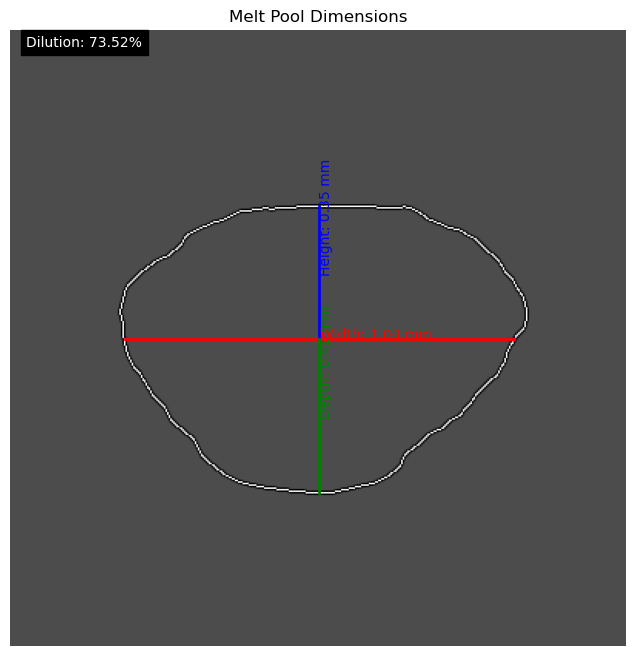

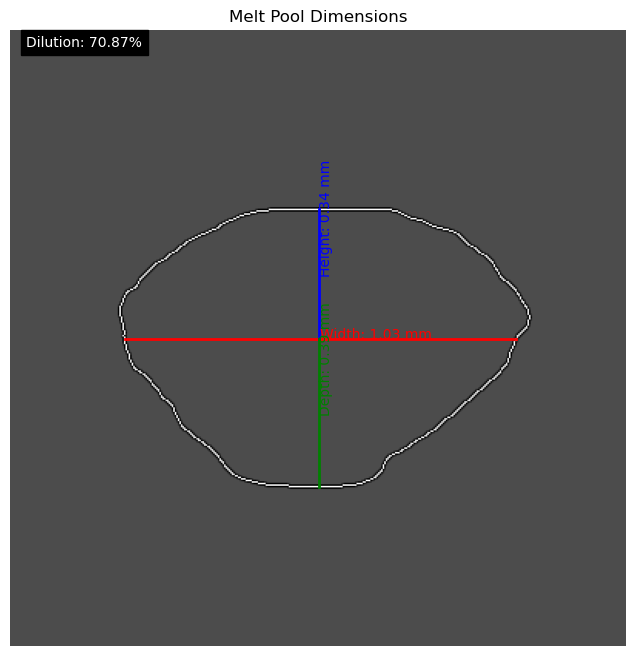

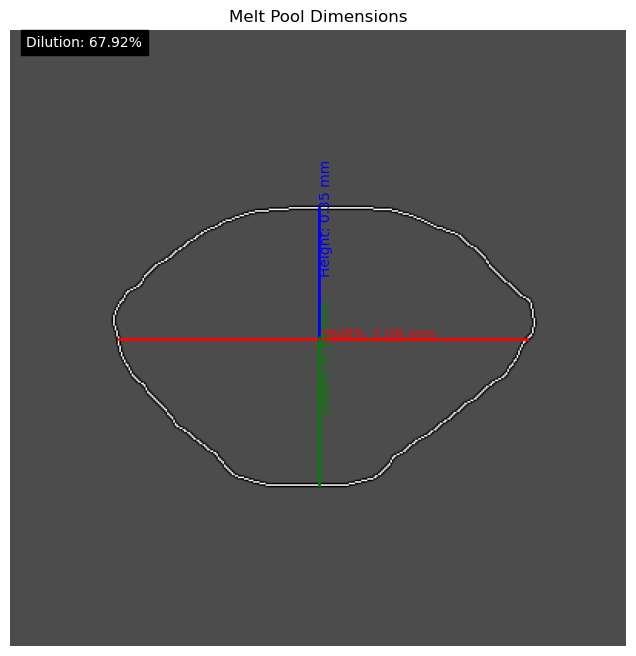

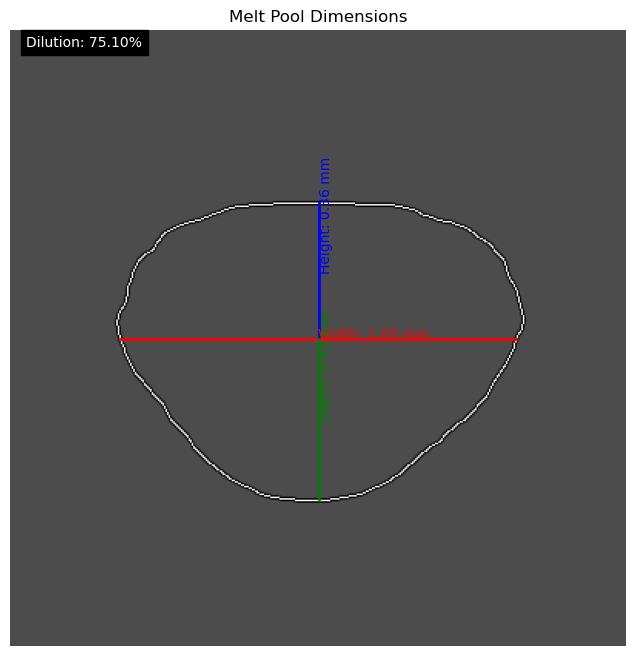

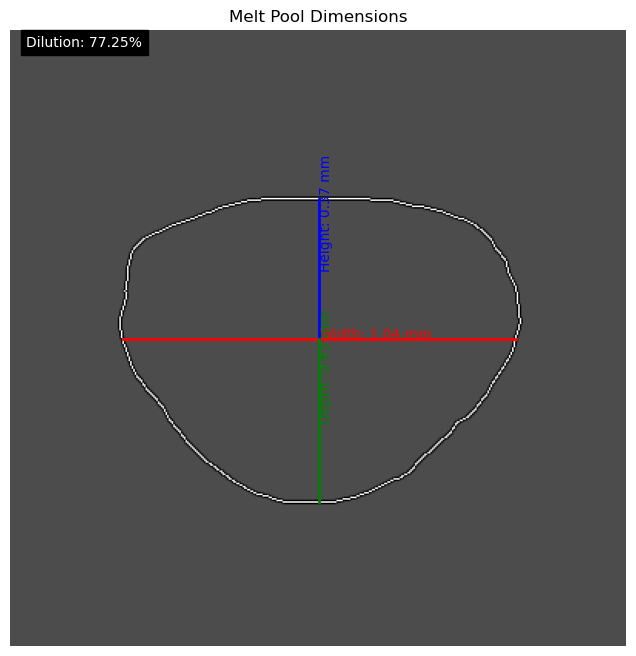

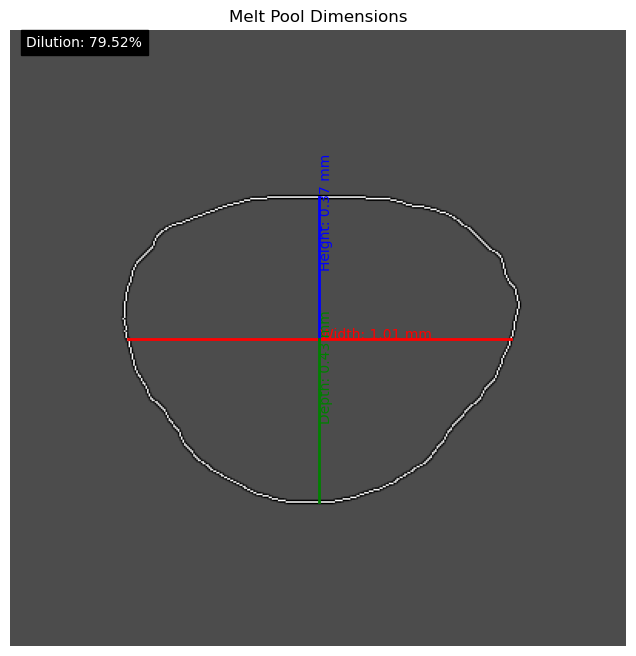

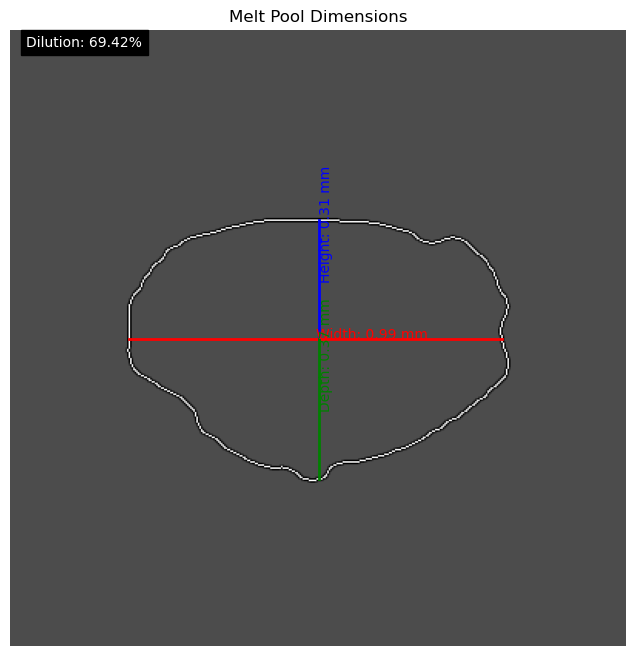

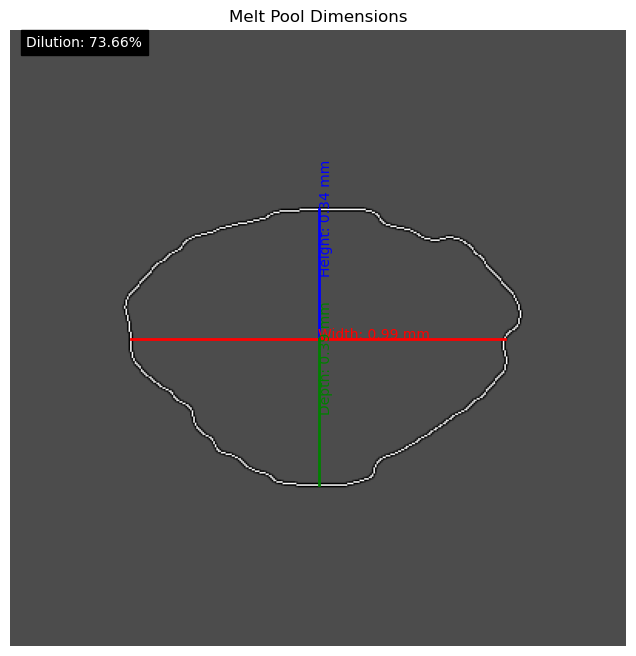

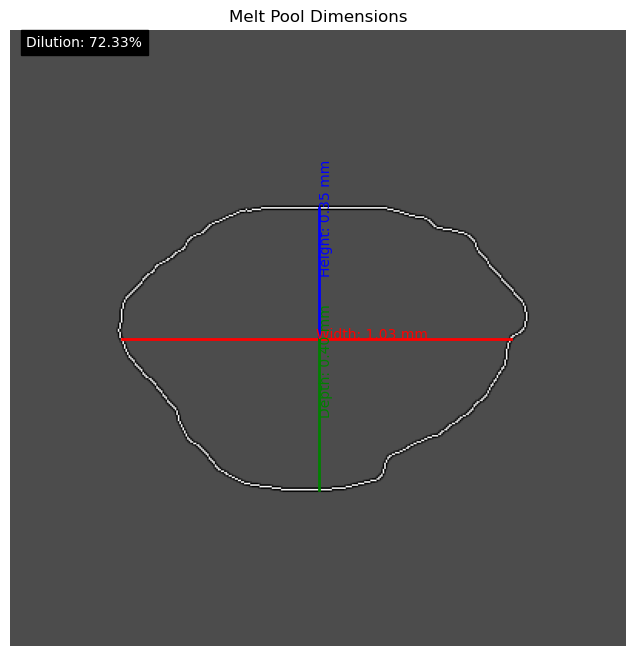

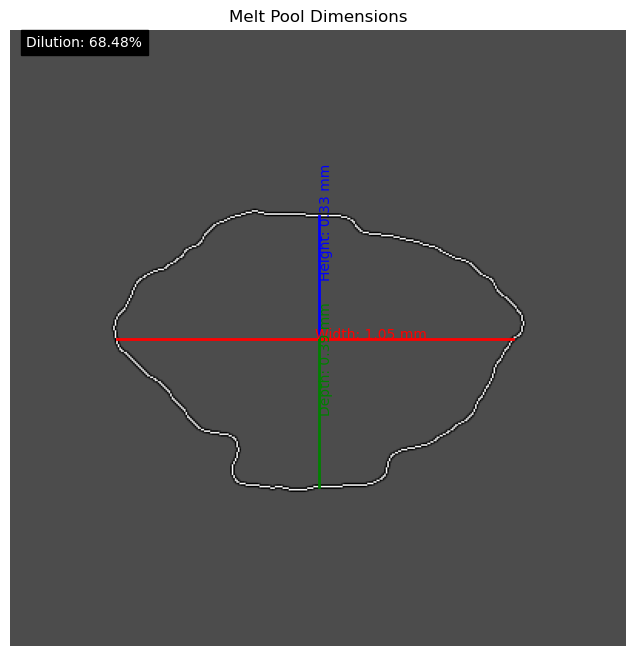

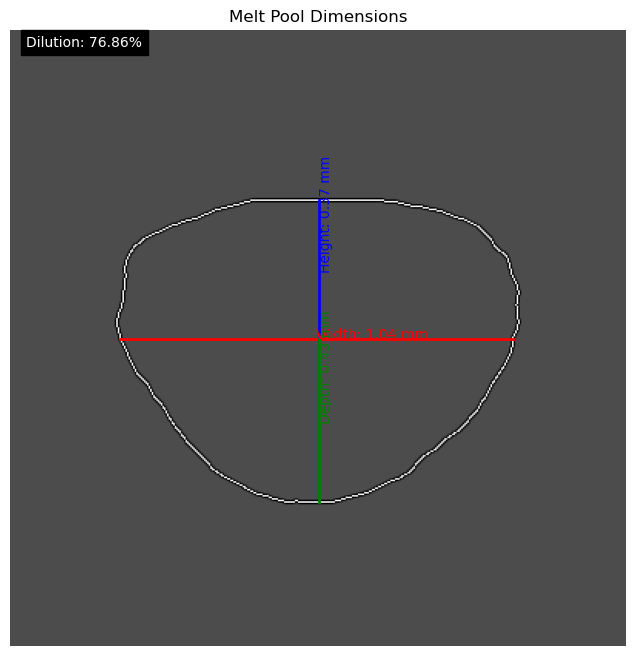

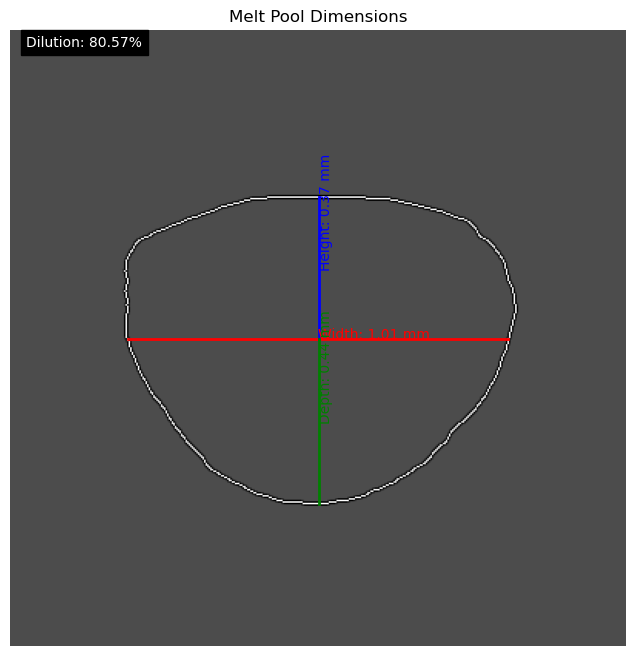

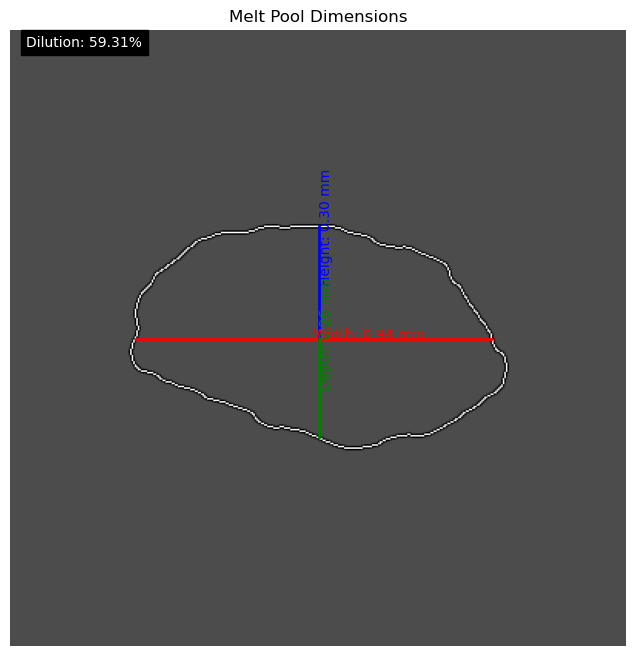

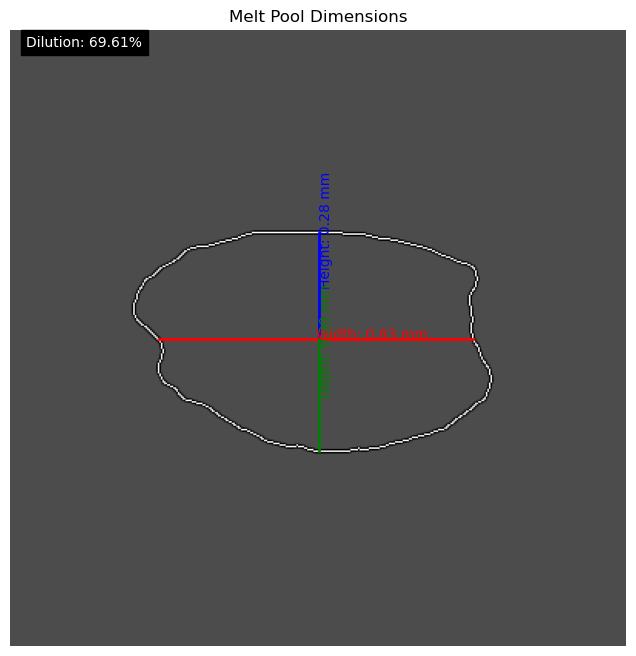

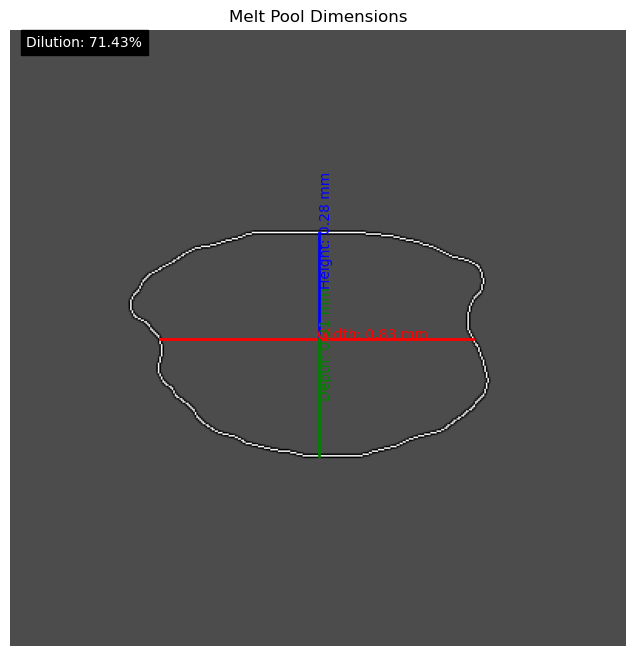

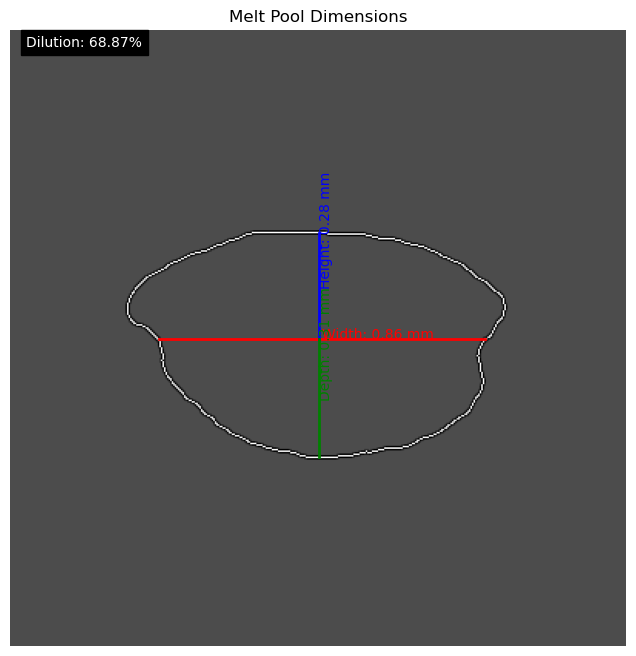

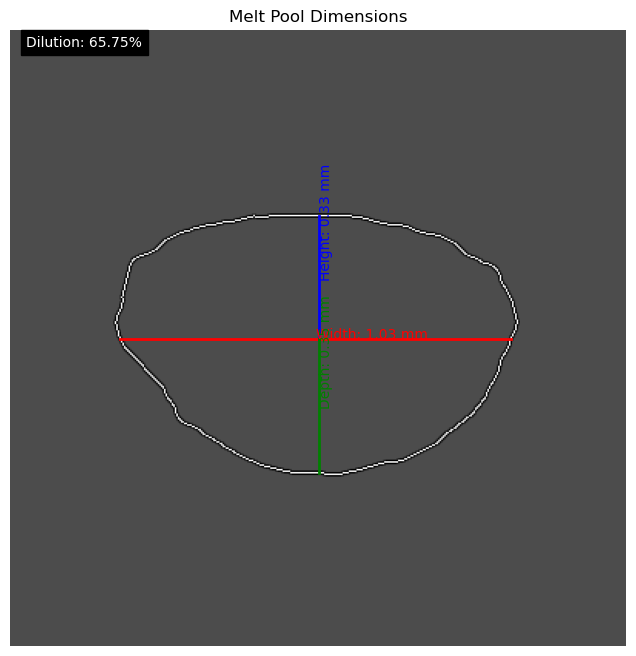

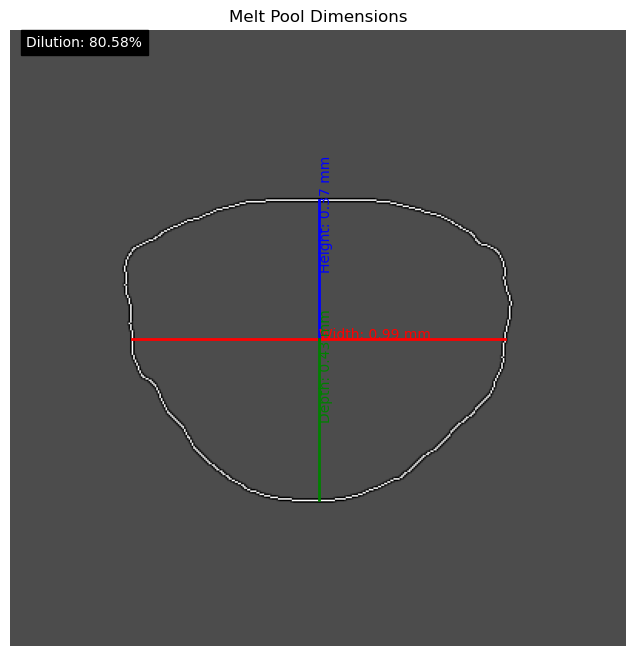

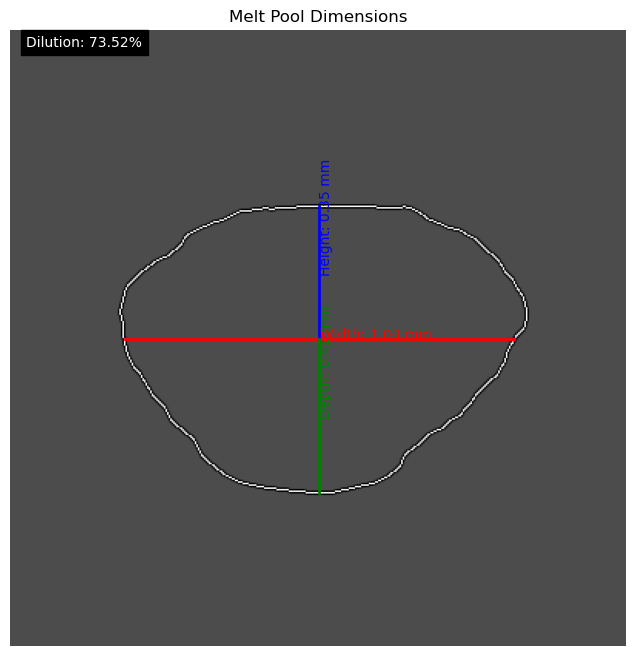

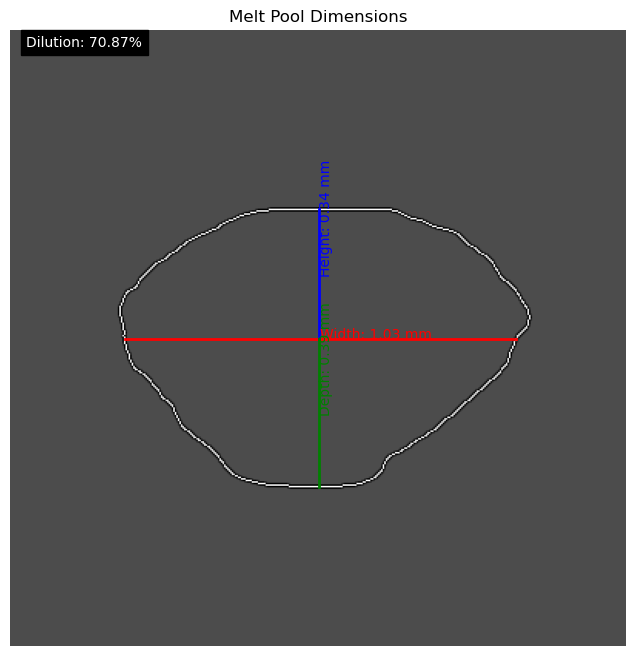

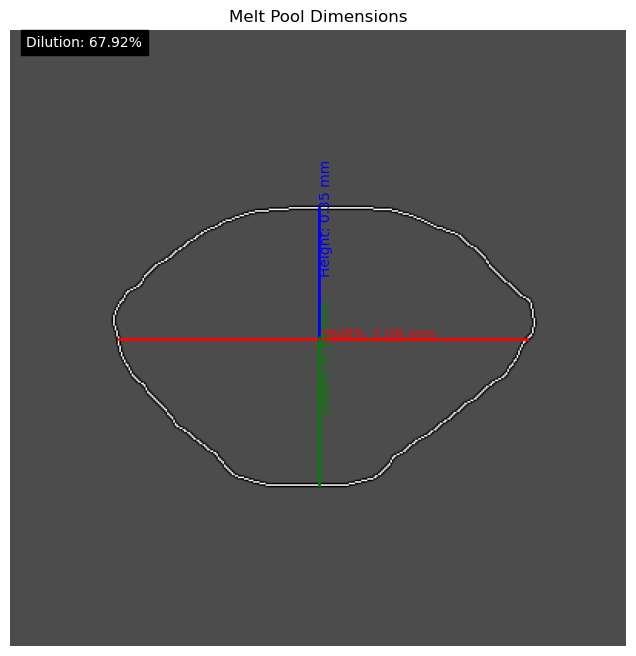

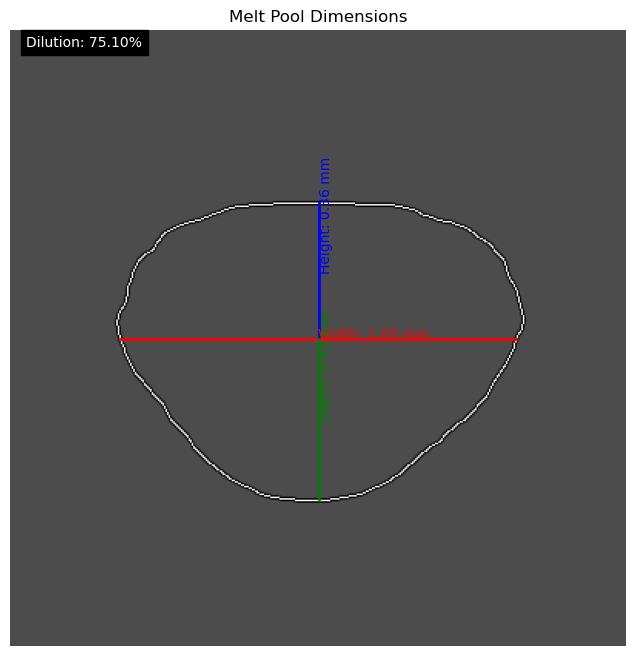

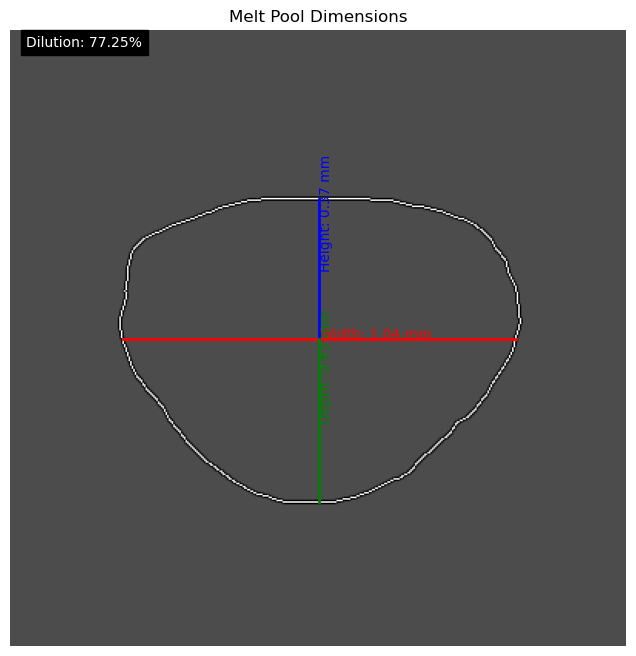

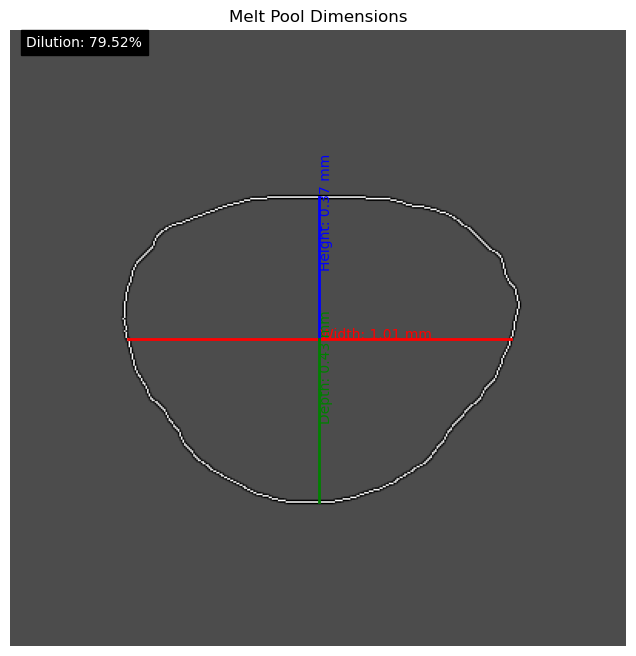

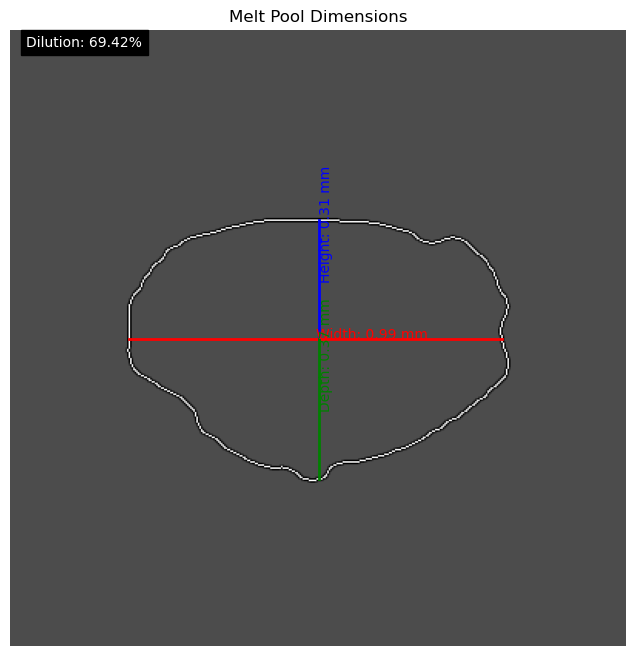

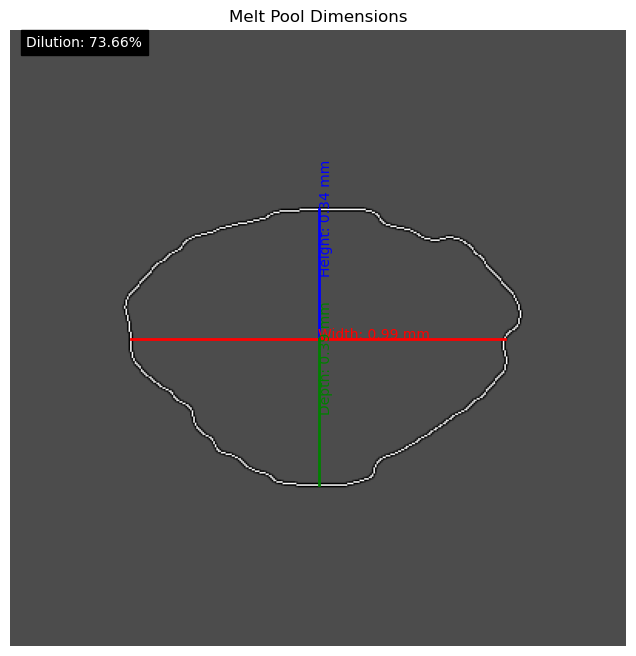

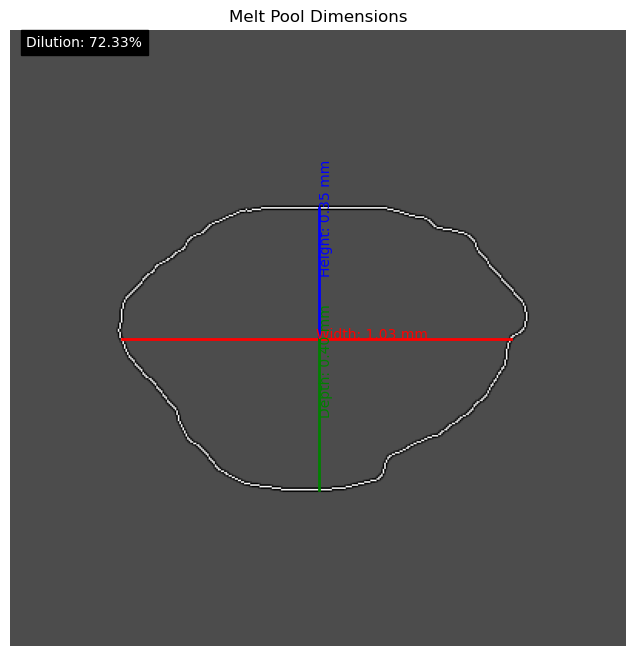

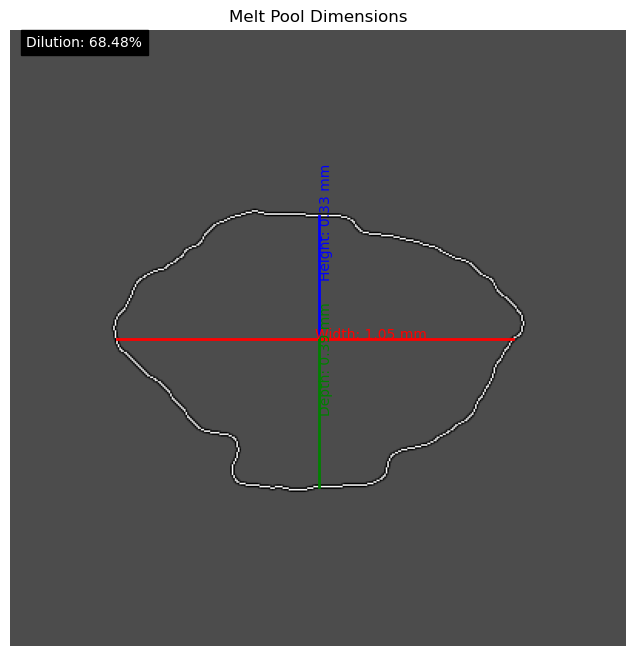

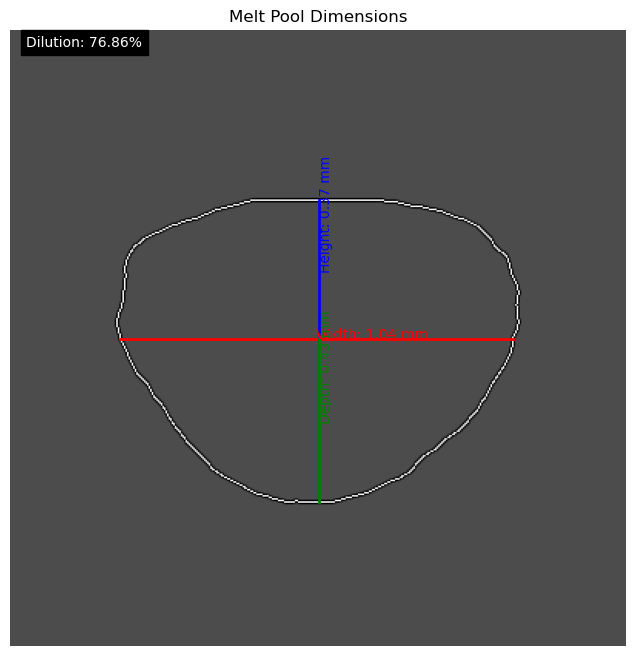

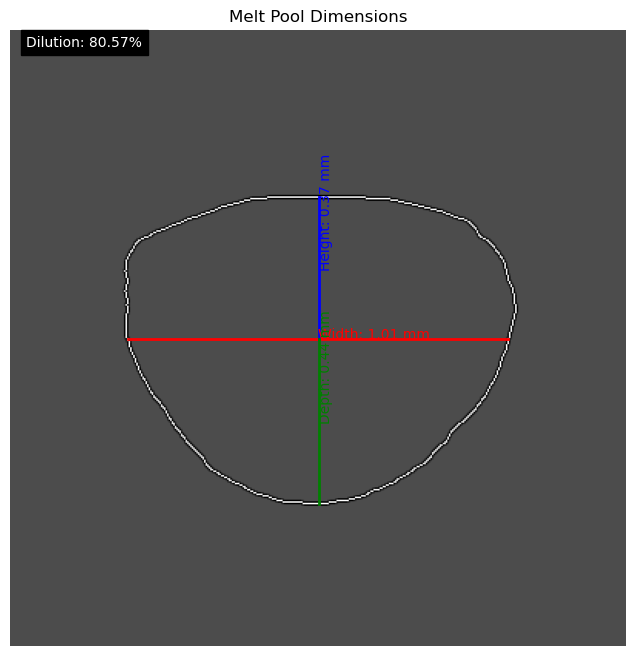

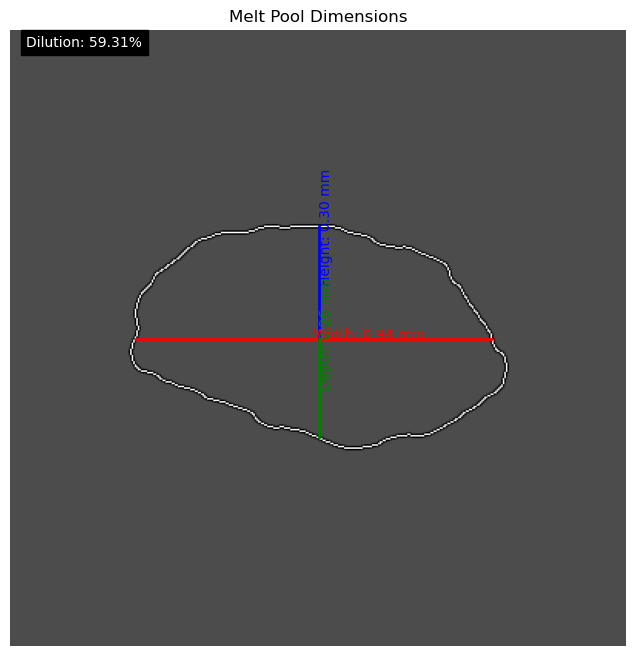

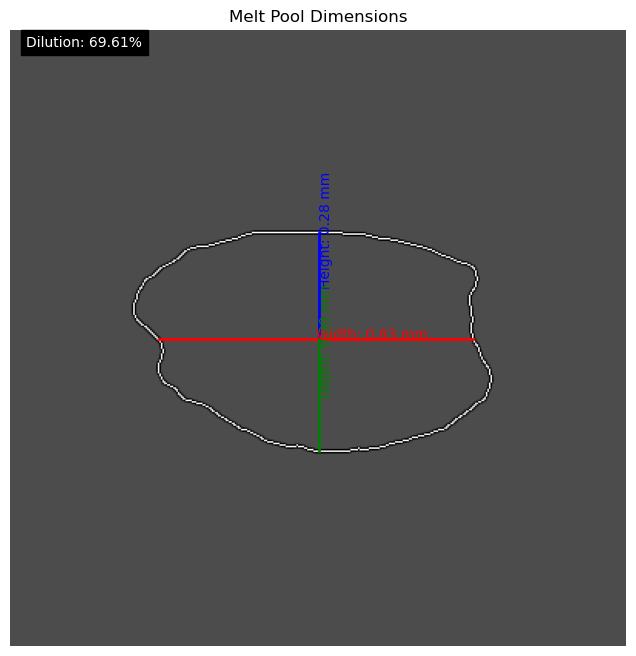

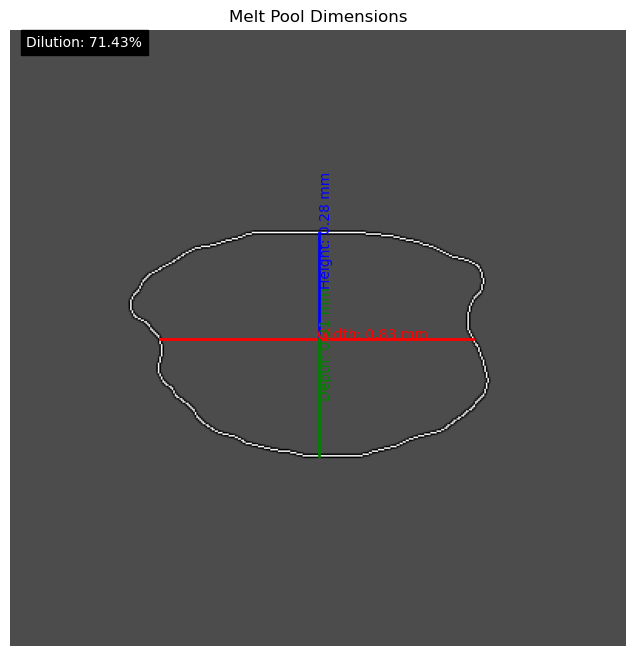

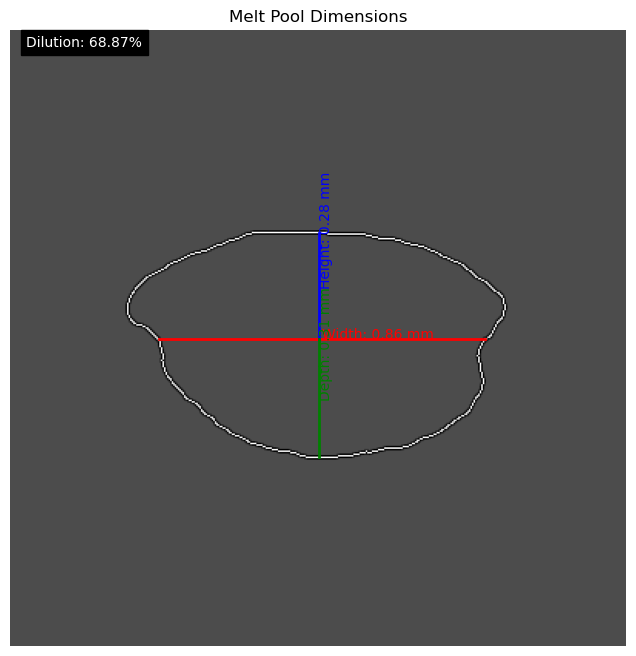

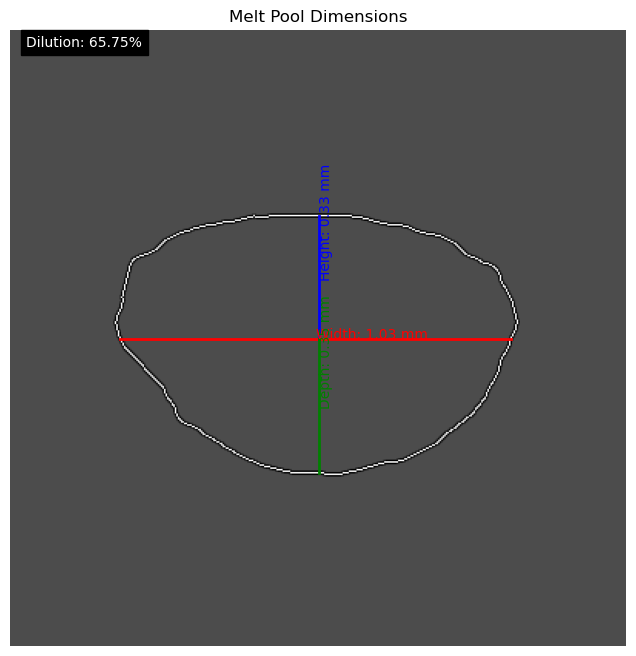

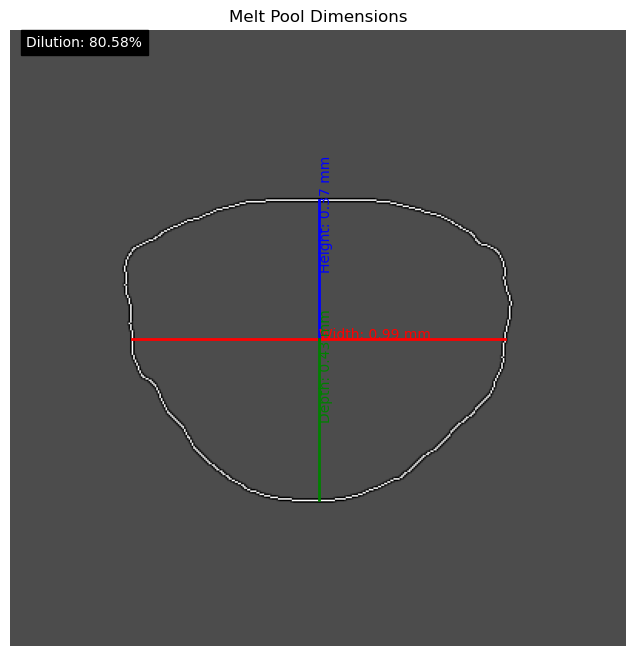

In [92]:
#the ouputs of the mp_pred function are width, height, depth, dilution, mp_contour, mp_contour_bi, We only need the width and height for now. Predict the width and height for each sample in the dataframe, where the inputs are the power, scan speed, and hatch spacing.

#add columns to the dataframe for width and height
df['Width'] = 0
df['Height'] = 0


#loop through each row in the dataframe
for i in range(len(df)):
    #predict the width and height for each sample TH_Co,TH_DF,S_H,D,
    if df['rpm_1'][i] != 0 and df['rpm_2'][i] != 0:
        TH_Co = 86.3995
        TH_DF = 22.4
        S_H = 433.5
        D = 8800 
    elif df['rpm_1'][i] == 0:
        TH_Co = 87.864
        TH_DF = 22.3
        S_H = 444
        D = 8900 
    else:
        TH_Co = 84.935
        TH_DF = 22.7
        S_H = 423
        D = 8860
        
    pred = process_and_visualize(df[' p_ls'][i],df['ss_ls'][i],df['rpm_1'][i]+df['rpm_2'][i] ,TH_Co,TH_DF,S_H,D)

    #add the width and height to the dataframe
    #Note: 4.97 used to correlate image mask to pixels 
    #Note: 0.0039957 used to correlate image pixels to mm 
    df['Width'][i] = pred[0]
    df['Height'][i] = pred[1]
df

In [93]:
#export the df dataframe as a csv file
df.to_csv('Optimized_20240219.csv')